# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2023
## Линейные модели

In [ ]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=11oDZ6JvJS0xP_u_YE55IFoX1C8TzDKQB

Downloading...
From: https://drive.google.com/uc?id=11oDZ6JvJS0xP_u_YE55IFoX1C8TzDKQB
To: /content/train.csv
100% 461k/461k [00:00<00:00, 152MB/s]


In [ ]:
import numpy as np
from scipy import stats as sps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

sns.set(font_scale=1.4, style='whitegrid')
%config InlineBackend.figure_format='retina'

В учебных целях в первой задаче запрещено использовать готовые реализации линейной регрессии (например, из пакета *scikit-learn*).

## Задача 1 (10 баллов)

На полигоне испытывается новая модель трамвая. В одном из испытании работы двигателя проверяется, что движение трамвая равномерно. Для проведения теста на трамвай установлен датчик, посекундно измеряющий пройденное расстояние.

Записи датчика можно описать такой моделью:

 $$X_i = \beta_1+i\beta_2+\varepsilon_0+\ldots+\varepsilon_i,\, i= 0, 1, \ldots, n$$

где $X_i$ --- расстояние, которое проехал трамвай за $i$ секунд. В модели $\beta_1$ --- начальное расстояние, $\beta_2$ --- скорость трамвая, $\varepsilon_0$ --- ошибка начального показания датчика. Отсчет времени идет от предыдущего замера, причем отсчет происходит с ошибкой. Для $i = 1, \ldots, n$ величина $\varepsilon_i$ есть ошибка приращения расстояния, то есть $\varepsilon_i = \varepsilon_i^t \beta_2,$ где $\varepsilon_i^t$ --- ошибка отсчета времени. Все ошибки $\varepsilon_i$ независимы и распределены по закону $N(0, \sigma^2)$.

Сведите задачу к линейной модели и найдите оценки наименьших квадратов для начального расстояния $\beta_1$ и скорости $\beta_2,$ а также несмещенную оценку для $\sigma^2,$ из которой выразите оценку дисперсии отсчета времени.

Данные возьмите из файла Regression.csv. Сделайте выводы.

### Решение

Загрузим датасет, содержащий показания датчика.

In [ ]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1gmSof1yxWt009QoBiKjwkLMlcpn3r61W

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1gmSof1yxWt009QoBiKjwkLMlcpn3r61W 



In [ ]:
X = np.genfromtxt('regression.csv')
print('Размер датасета:', X.shape)
print('Средняя скорость:', X[-1] / X.shape[0])

Размер датасета: (1000,)
Средняя скорость: 12.0408175


Датасет состоит из 1000 измерений. По смыслу средняя скорость имеет размерность метры в секунду.

In [ ]:
from scipy import integrate
def f(x):
  return np.exp(x)*(x**2)
v, err = integrate.quad(f, -1, 1, points=[0])
v,err

(0.8788846226018336, 9.75757944001547e-15)

Визуализируйте выборку и сделайте выводы о том, верно ли что линейная регрессионная модель имеет смысл

Text(0, 0.5, 'Расстояние')

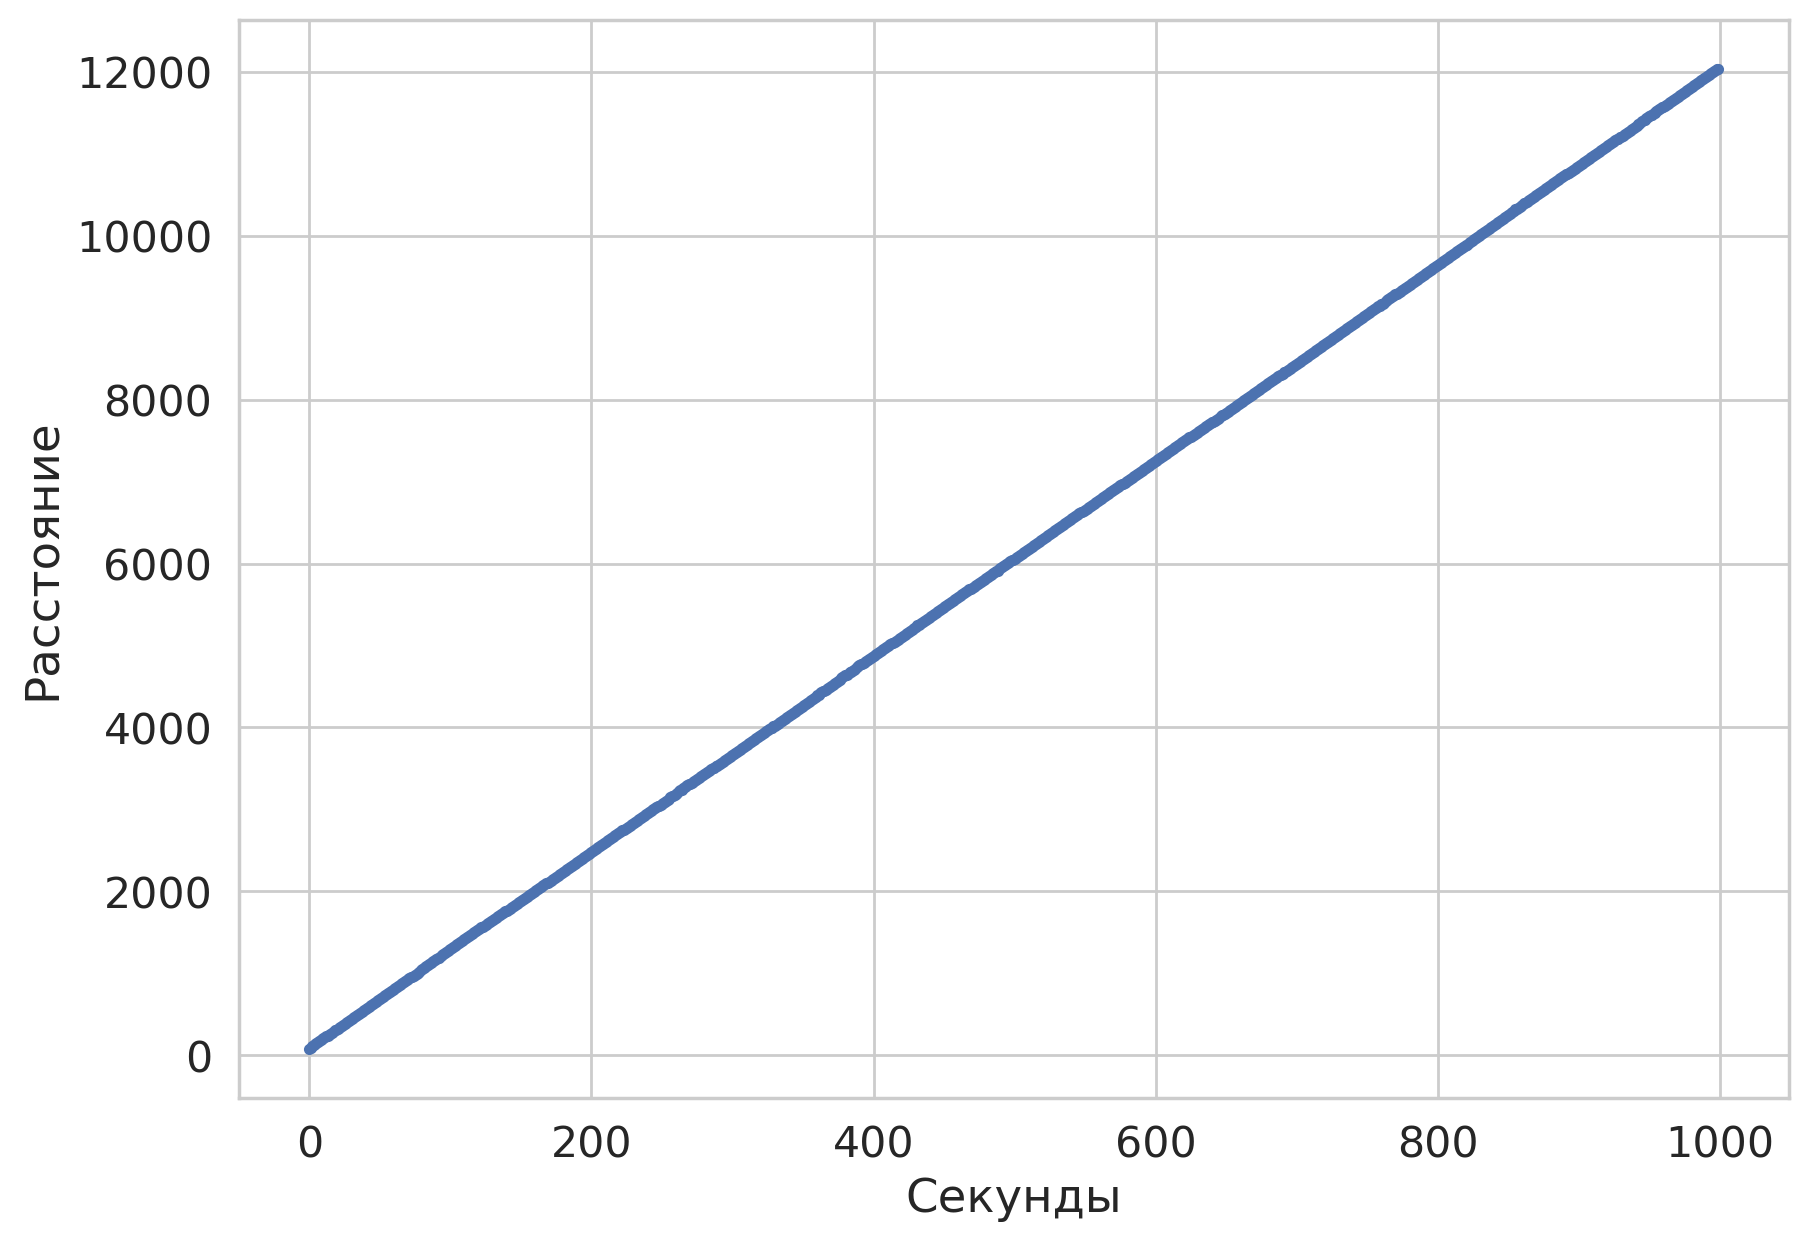

In [ ]:
iter = [i for i in range(len(X))]
plt.figure(figsize=(10, 7))
plt.plot(iter, X, marker = 'o', markersize=3)
plt.xlabel('Секунды')
plt.ylabel('Расстояние')

#### 1. Сведите задачу к гауссовской линейной модели (определения брать из основного курса)

Для начала можно увидеть, что изначальная задача не удовлетворяет линейной модели, нам надо поменять вид вектора X. Сделаем это так:<br>
$$ Y =
\left(\begin{array}{cc}
X_0 \\
X_1 - X_0 \\
X_2 - X_1 \\
\dots \\
X_n - X_{n-1} \\
\end{array}\right) =
\left(\begin{array}{cc}
\beta_1 + \varepsilon_0 \\
\beta_2 + \varepsilon_1 \\
\beta_2 + \varepsilon_2 \\
\dots \\
\beta_2 + \varepsilon_n \\
\end{array}\right),
$$
и Y - наши новые наблюдения. Но по факту мы сразу сделали два шага, потому что Y имеет еще и вид, который задан в гауссовской линейной модели, а именно $Y = l + ϵ$ (по методичке), где $l = ZΘ$, $Θ$ зависит от $β_1, β_2$, а ϵ - все также ошибка, причем мы его не трогали, а значит ϵ ~ $N(0, σ^2) (вычитание по свойствам нормального распределения не меняет ничего)$.

In [ ]:
Y = np.append(X[0], X[1:] - X[:-1])

#### 2. Распишите и проверьте требования к гауссовской линейной модели

Рекомендуется писать некоторое требование теоретически, описать способ его проверки и визуализировать проверяемые величины (мат. ожидания, дисперсии, зависимости).

В рамках этого задания наличие зависимости можно проверять исключительно визуально. Если у Вас есть желание разобраться самостоятельно в критериях независимости и коэффициентах корреляции, это поощряется (но не требуется)

Еще раз вспомним, что ϵ ~ $N(0, σ^2I)$, 0 - вектор. Значит нам надо проверить, что среднее значение ошибки равно нулю и при этом для всех измерений ошибки имеют одинаковую дисперсию.

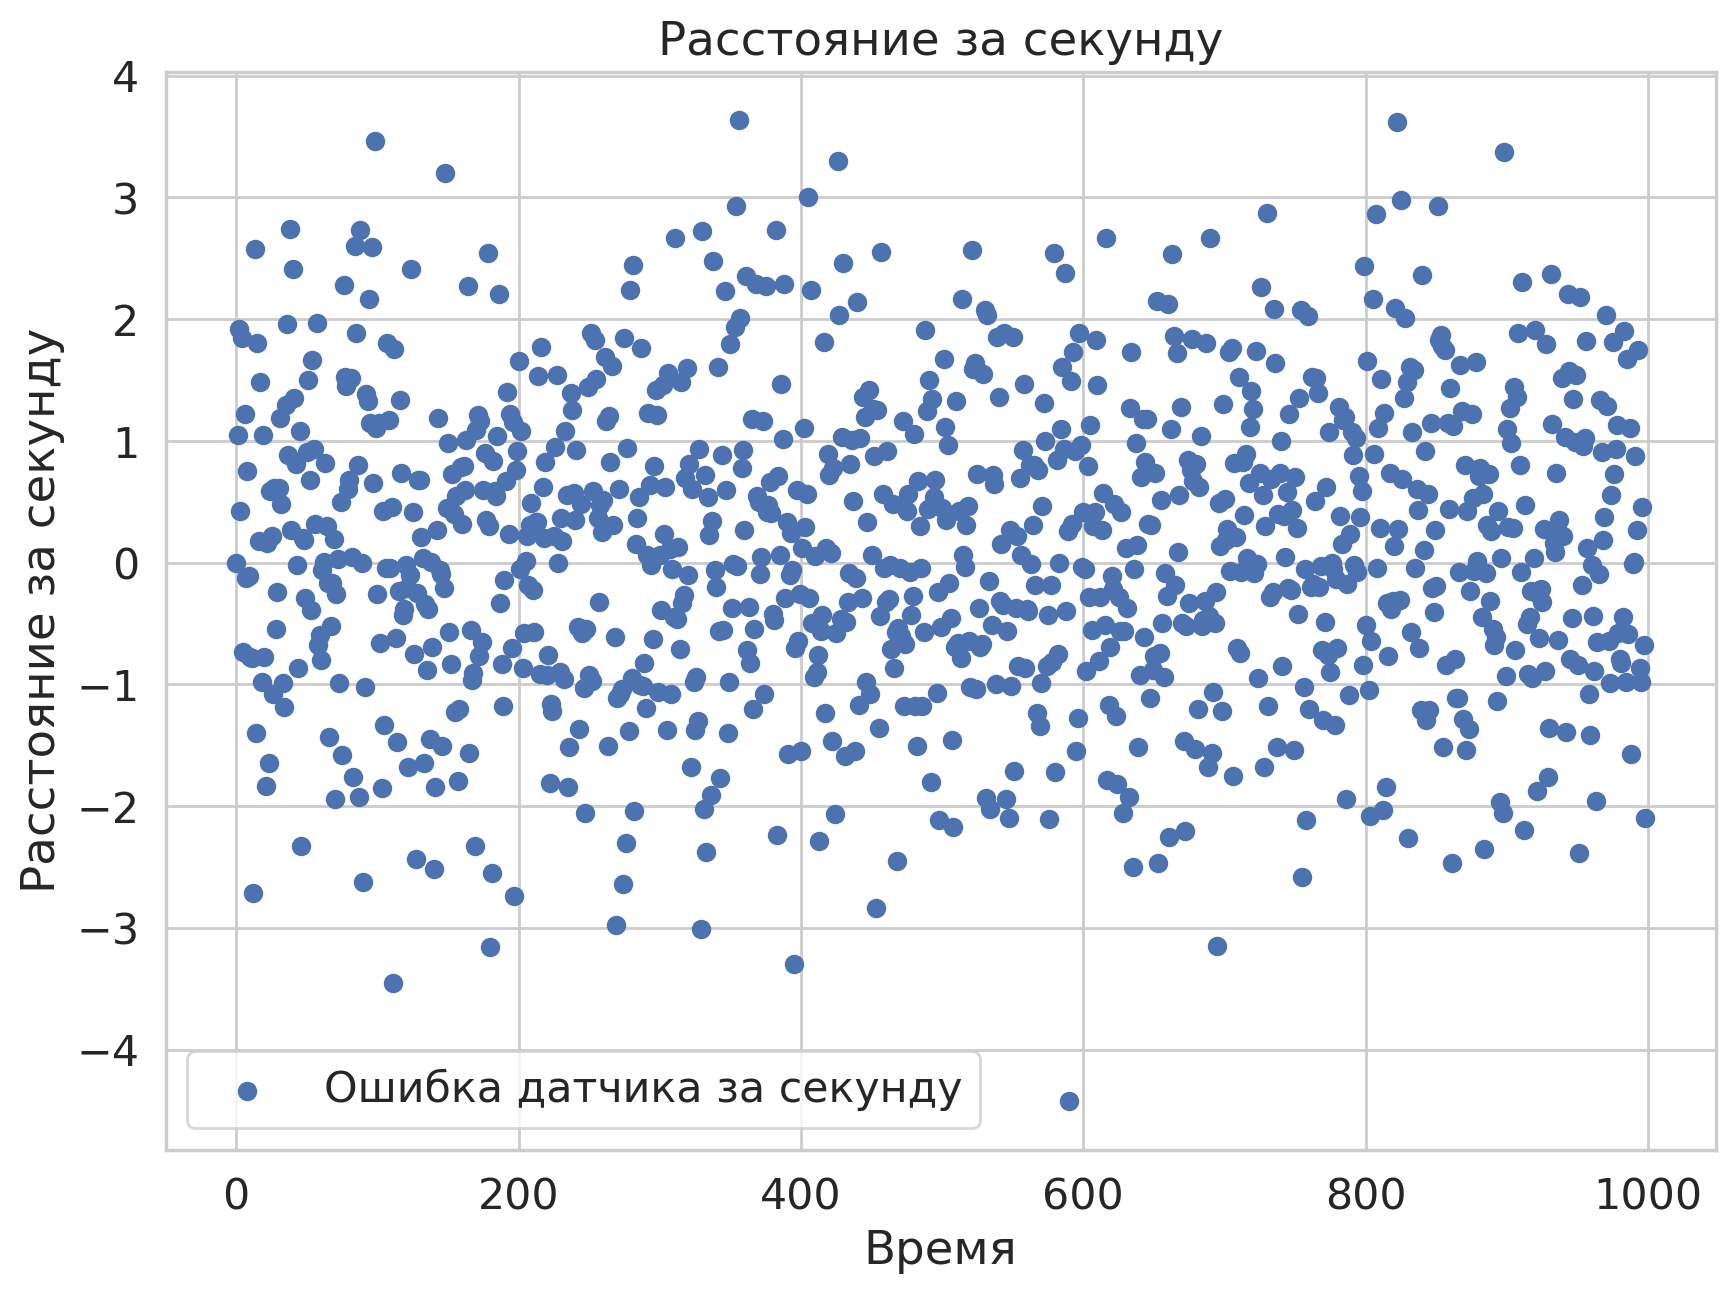

In [ ]:
plt.figure(figsize=(10, 7))
iter = iter[:-1]
plt.title('Расстояние за секунду')
plt.scatter(iter, Y[1:] - Y[1], label='Ошибка датчика за секунду')
plt.xlabel('Время')
plt.ylabel('Расстояние за секунду')
plt.legend()

Теперь проверим, что ошибка имеет нормальное распределение. Воспользуемся предложенным ниже QQ-plot(ом).

Проверьте, что ошибка нормальна. Для этого можно использовать QQ-plot. Если хотите, можете использовать критерии нормальности

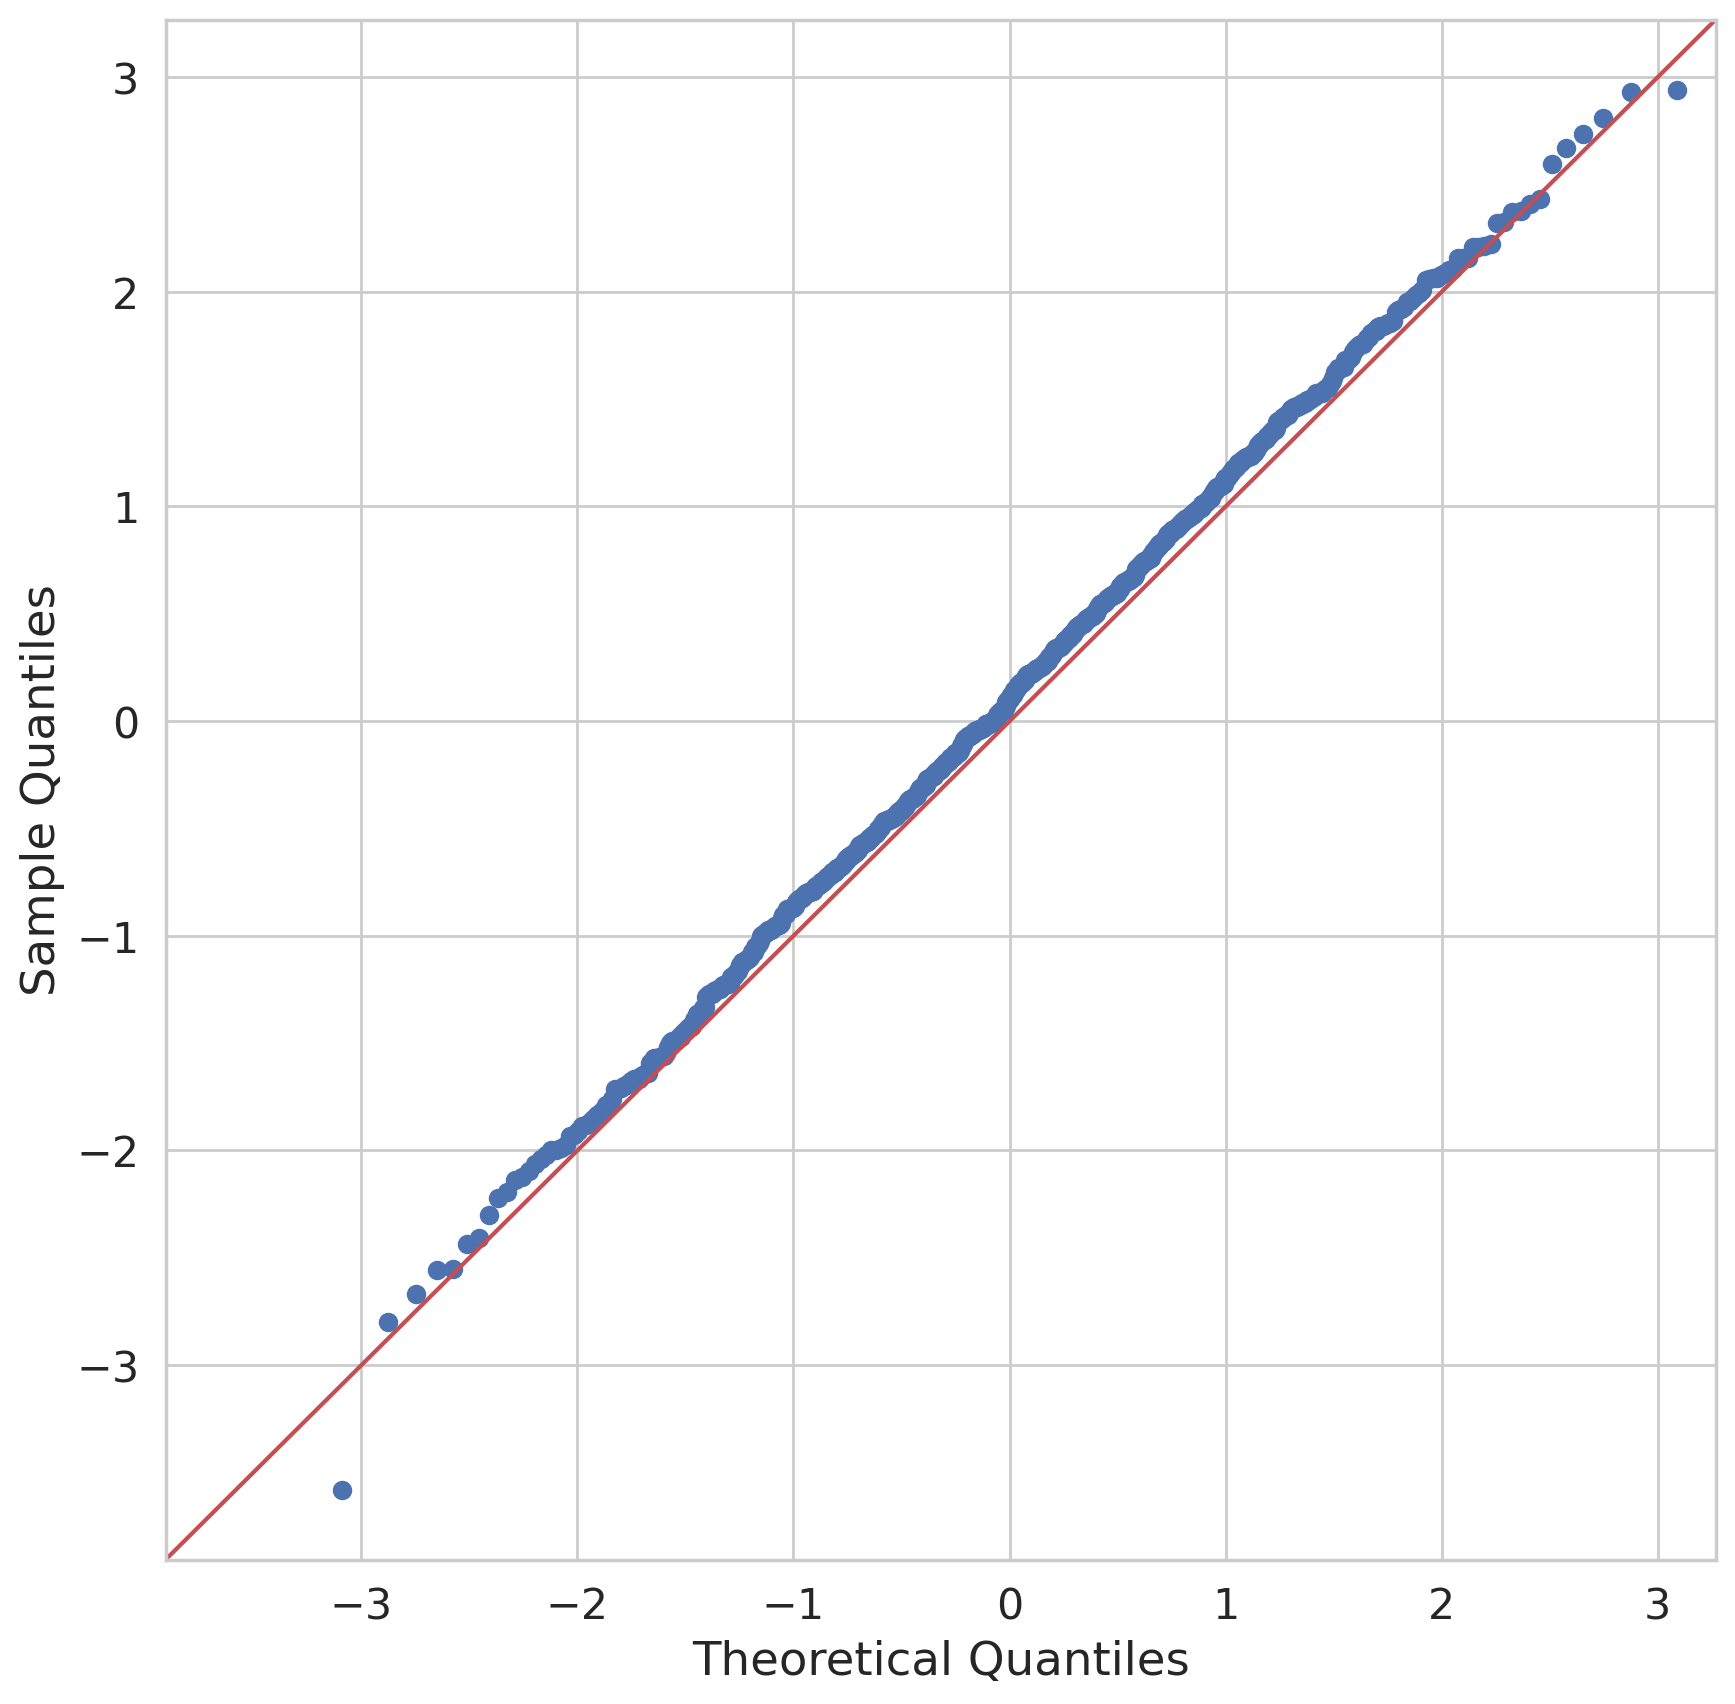

In [ ]:
Y_new = (Y[1:] - Y[1]) / np.std(Y[1:] - Y[1])
fig, ax = plt.subplots(figsize=(10, 10))
sm.qqplot(Y_new, line='45', ax=ax, dist=sps.norm)
print()

**Промежуточный вывод:** Проделанные эксперименты дают нам полное основание полагать, что ошибка распределена нормально, так как график хорошо ложиться на прямую y = x.

#### 3. Найдите оценку параметров

Укажите, чему равна матрица (Z в терминах методички) в задаче:<br>
Как уже говорилось раньше
$
θ =
\left(\begin{array}{cc}
β_1 \\
β_2 \\
\end{array}\right)
$,
$
Z =
\left(\begin{array}{cc}
1 & 0 \\
0 & 1 \\
… & … \\
0 & 1 \\
\end{array}\right)
$ - размера (n × 2).<br>
И тогда наша линейная модель представляется (как уже говорилось ранее) в таком виде: $Y = l + ϵ = Zθ + \varepsilon$.<br>


И найдите параметры $\beta_1$, $\beta_2$

Оценки на параметры будем делать с помощью МНК:<br>
$$
\hat{θ} = \arg \min_θ ||Y - Zθ||^2
$$
На курсе машинного обучения выводилось аналитическое решение этой задачи.
$$
\hat{θ} = (Z^TZ)^{-1}Z^TY
$$
Надо учесть, что тут мы надеемся, что матрица $Z^TZ$ будет обратимой, в общем случае же решение выглядит так: $(Z^TZ + αI)^{-1}Z^TY$ - это решает проблему необратимости (обычно α берут некоторым достаточно малым числом).

In [ ]:
Z = np.array([1, 0] + [0, 1] * (len(Y) - 1))
Z = Z.reshape((len(Y), 2))
Z

array([[1, 0],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [ ]:
estimation = np.linalg.inv(Z.T @ Z) @ Z.T @ Y
estimation

array([82.0053    , 11.97078298])

In [ ]:
print(str(estimation[0]) + '- начальное расстояние,', str(estimation[1]) + '- скорость')

82.0053- начальное расстояние, 11.970782982982989- скорость


Проверьте, насколько точна модель при помощи подсчёта ошибок. Выведите сами ошибки на график и проанализируйте его.

Бонусная часть (+5 баллов):

Возможно измерения в задаче содержат разные аномалии, что плохо скажется на оценке наименьших квадратов. Попробуйте применить знания из предыдущей домашки о робастных оценках и построить оценку с BP выше нуля. Такие методы называются "робастной регрессией", но определение M-оценки в них то же, что и в обычной робастной статистике.

#### 4. Оцените дисперсию ошибки показаний датчика.

Найдите оценку дисперсии $\sigma^2$ показаний датчика $\varepsilon$ (ошибки регрессионной модели). После того, как она найдена, найдите оценку дисперсии $\sigma^2$ ошибки отсчёта времени $\varepsilon^t$ (исходной ошибки).

Для несмещенной оценки дисперсии $σ^2$ можем воспользоваться такой формулой: $\frac{1}{n - k}||Y - Z\hat{θ}||_2^2$, тут в нашем случае n = 1000 (размер выборки), k = 2 (размер θ).

In [ ]:
n = 1000
k = 2
sigma_estim = (1 / (n - k)) * (np.linalg.norm(Y - Z @ estimation) ** 2)
print('Несмещенная оценка дисперсии: ' + str(sigma_estim))

Несмещенная оценка дисперсии: 1.525244871613911


Теперь найдем оценку дисперсии отсчета времени, то есть $\varepsilon^t_i$. Как было написано в условии задачи, ошибка расстояния связана с ошибкой приращения такой формулой: $\varepsilon = \varepsilon^tβ_2$. Мы знаем, что $\varepsilon$ ~ $N(0, σ^2)$, тогда $\varepsilon^t$ ~ $N(0, \dfrac{σ^2}{β_2^2})$

In [ ]:
eps_t = sigma_estim / estimation[1] ** 2
print('Оценка дисперсии ошибки отсчета времени ' + str(eps_t))

Оценка дисперсии ошибки отсчета времени 0.01064374492492206


#### 5. Измерьте качество модели

В качестве метрики качества модели, эксперты предложили использовать [коэффициент детерминанции](https://ru.wikipedia.org/wiki/Коэффициент_детерминации). Он показывает какую долю дисперсии выборки объясняет линейная регрессия. В нашем случае, значение $R^2 > 0.98$ будет означать, что трамвай прошел испытание.

Изучите что такое коэффициент детерминации и сделайте выводы о том, почему большой коэффициент говорит о высоком качестве модели

Ответ: Как видим ниже, доля дисперсии, которую мы покрыли очень близка к 1, а значит качество модели хорошее. А ошибка при этом действительно имеет нормальное распределение.

In [ ]:
iter = np.array([i for i in range(len(X))])
S_res = np.array([estimation[0] + estimation[1] * iter - X])
R = 1 - (np.linalg.norm(S_res) ** 2) / (np.linalg.norm(estimation[0] + estimation[1] * iter - np.mean(X)) ** 2)
print(R)

0.9999894819209986


Как альтернатива коэффициенту детерминации есть коэффициенты AIC (https://en.wikipedia.org/wiki/Akaike_information_criterion) и BIC (https://en.wikipedia.org/wiki/Bayesian_information_criterion). Найдите их и проинтерпретируйте их значения.

Итоговый ответ к задаче:<br>
$β_1 = 82.0053$, $β_2 = 11.970782982982989$, $σ^2 = 1.525244871613911$, $σ^2_t = 0.01064374492492206$.

## Задача 2 (5 баллов)

Непараметрическая регрессия и метод Надарая-Ватсона.

Иногда вытаскивать информативные признаки из данных сложно, а регрессию делать хочется. Тогда можно построить нечто похожее на ядерную оценку плотности, но для регрессионной задачи. Она основана на вычислении значения в новой точке по значениям в соседних точках (похожее Вы видели на курсе машинного обучения, но для классификации и без статистики).

Изучите формулу Надарая-Ватсона из статьи на википедии: https://en.wikipedia.org/wiki/Kernel_regression

1) Сгенерируйте выборку для линейной регрессии руками (использовать реальные данные может быть нецелесообразно из-за проблем с визуализацией результата и проклятия размерностей).

Пусть в модели будет одна фича x и по ней вычисляется отклик y = ax + b + $\epsilon$, где ошибка независима и нормальна, а параметры выберите сами.

Сгенерируйте тестовую выборку тем же способом и посчитайте отклик из формулы Надарая-Ватсона для хотя бы трёх разных ядер (примеры ядер: https://en.wikipedia.org/wiki/Kernel_(statistics)). Сравните ошибки.

Визуализируйте Ваши предсказания (постройте кривую предсказаний по сетке x с шагом 0.01)

Заметим, что мы нигде не оценивали сами параметры, но смогли решить финальную задачу -- предсказывать y по x.

А теперь поймём что для этого не нужна линейность.

Проделайте рассуждения выше для нелинейных зависимостей ($y = sin(kx), y = log(x), y = x^k$. Постройте графики предсказаний и сравните их с истинными функциями.

**Вывод:**

Можете попробовать применить метод Надарая-Ватсона для выборки из задачи 3 и посмотреть, что получится (0 баллов)

## Задача 3 (15 баллов)

Теперь давайте попрактикуемся в решении задач на реальных данных. Мы будем анализировать рынок недвижимости 🏘. Данные возьмем из [соревнования](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) на платформе kaggle. В отличие от соревнований нас будут интересовать зависимости в данных, а не более точные предсказания.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png).

В частности мы будем смотреть на влияние различных признаков на стоимость дома и проверим несколько гипотез.

In [ ]:
from scipy import stats as sps

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [ ]:
df = pd.read_csv("train.csv")

df.fillna("NA", inplace=True)
df.head()

Id  MSSubClass MSZoning LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL        65.0     8450   Pave    NA      Reg   
1   2          20       RL        80.0     9600   Pave    NA      Reg   
2   3          60       RL        68.0    11250   Pave    NA      IR1   
3   4          70       RL        60.0     9550   Pave    NA      IR1   
4   5          60       RL        84.0    14260   Pave    NA      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
1         Lvl    AllPub  ...        0     NA    NA          NA       0      5   
2         Lvl    AllPub  ...        0     NA    NA          NA       0      9   
3         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
4         Lvl    AllPub  ...        0     NA    NA          NA       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [ ]:
useful_columns = [
    "OverallQual",
    "GrLivArea",
    "ExterQual",
    "KitchenQual",
    "GarageArea",
    "PoolArea",
    "BsmtQual",
    "TotalBsmtSF",
    "GarageFinish",
    "SalePrice"
]

Можно заметить, что в данных присутствуют категориальные признаки, которые при этом не лишены порядка.

Вспомните курс машинного обучения. Как можно обработать категориальные призаки, чтобы регрессионная модель была осмысленна?

Ответ: Видим, что есть категориальные признаки, которые принимают значения строк, но мы можем заменить каждую строку (через словарь) на некоторое число, при это сохранив порядок. Сделаем это!

In [ ]:
data = df[useful_columns]
transforms = {
    "BsmtQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "ExterQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "GarageFinish": {"NA": 0, "Unf": 1, "RFn": 2, "Fin": 3},
}
for column, key in transforms.items():
  data[column] = data[column].apply(lambda x: key[x])

<ipython-input-10-c25ae7591336>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = data[column].apply(lambda x: key[x])


In [ ]:
data

OverallQual  GrLivArea  ExterQual  KitchenQual  GarageArea  PoolArea  \
0               7       1710          4            4         548         0   
1               6       1262          3            3         460         0   
2               7       1786          4            4         608         0   
3               7       1717          3            4         642         0   
4               8       2198          4            4         836         0   
...           ...        ...        ...          ...         ...       ...   
1455            6       1647          3            3         460         0   
1456            6       2073          3            3         500         0   
1457            7       2340          5            4         252         0   
1458            5       1078          3            4         240         0   
1459            5       1256          4            3         276         0   

      BsmtQual  TotalBsmtSF  GarageFinish  SalePrice  
0            4          856             2     208500  
1            4         1262             2     181500  
2            4          920             2     223500  
3            3          756             1     140000  
4            4         1145             2     250000  
...        ...          ...           ...        ...  
1455         4          953             2     175000  
1456         4         1542             1     210000  
1457         3         1152             2     266500  
1458         3         1078             1     142125  
1459         3         1256             3     147500  

[1460 rows x 10 columns]

### Визуализируйте данные

Перед тем, как начать использовать линейные модели необходимо убедиться в том, что столбцы признаков не слишком коллинеарны. Для этого можно использовать корреляцию Пирсона. Используя ``sns.heatmap`` постройте "тепловую карту" попарных корреляций признаков. Для того, чтобы увидеть числовые значения корреляций используйте ``annot=True``. Сделайте размер графика алекватным, например, ``figsize=(11, 10)``.

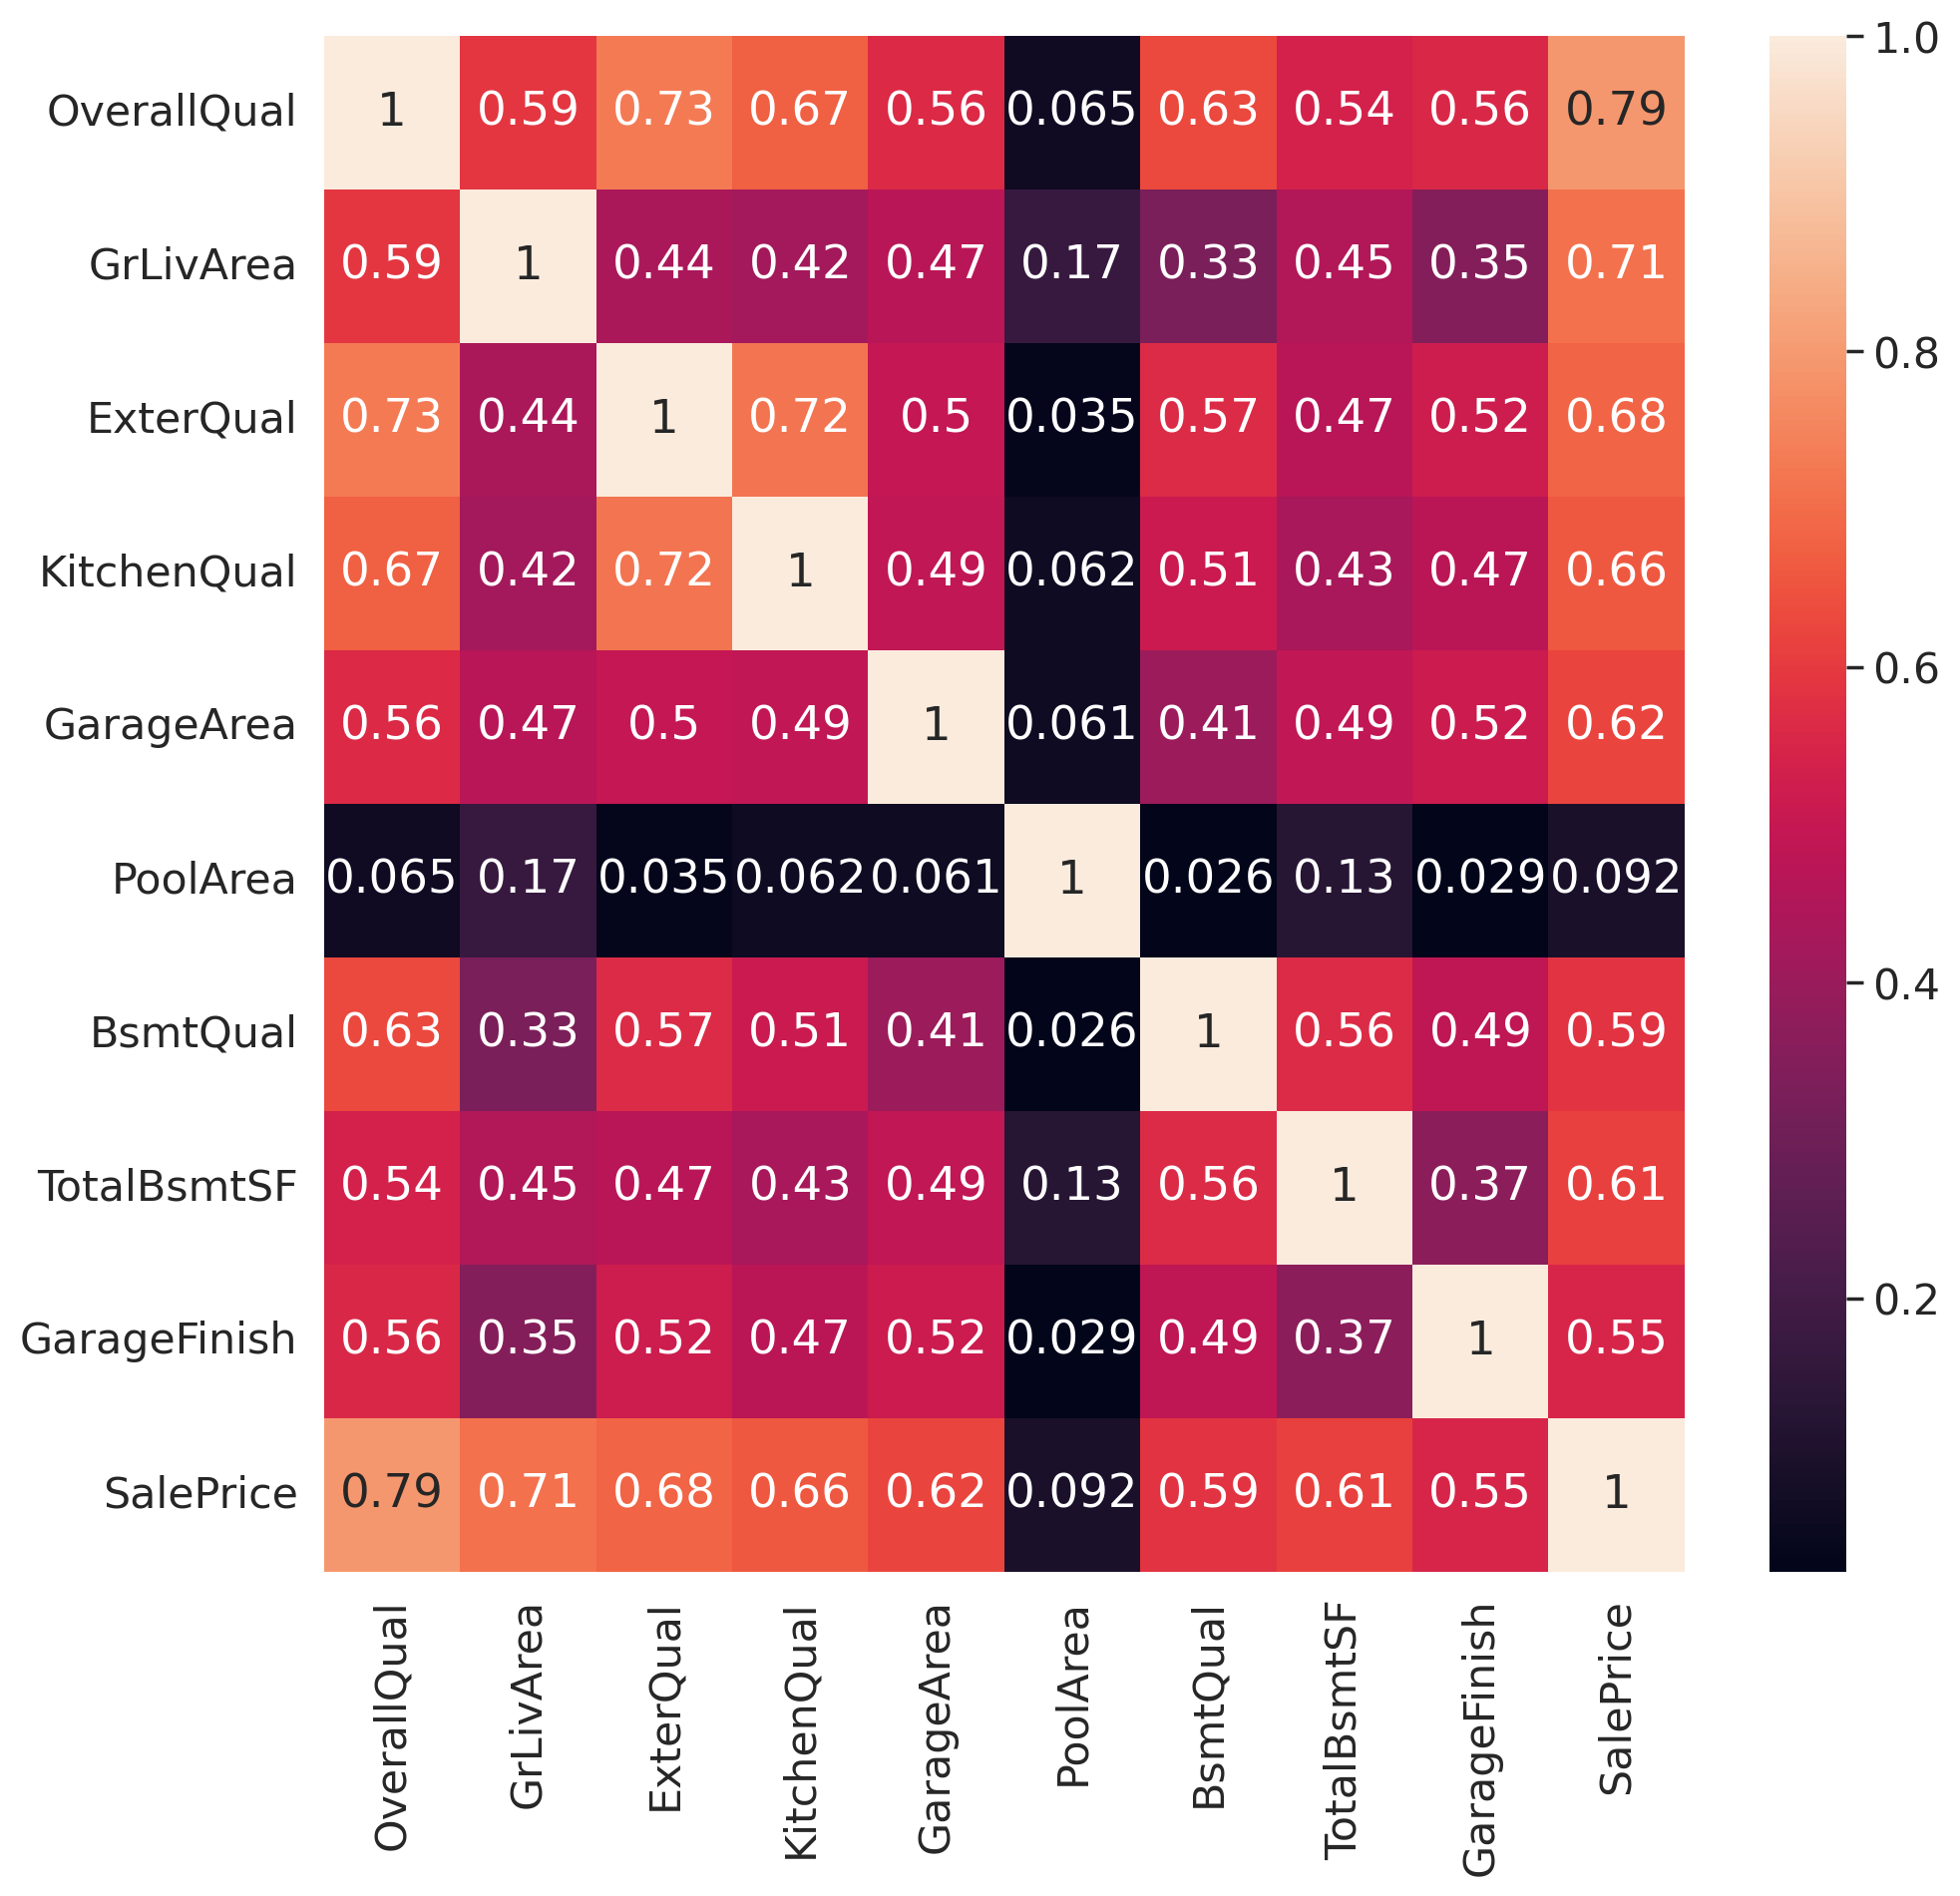

In [ ]:
plt.figure(figsize=(11, 10))
sns.heatmap(data.corr(method='pearson'), annot=True)
plt.show()

Изучите карту и сделайте по ней выводы о зависимости в данных ($|r_{XY}| > 0.9$). А чем плохи зависимые признаки? Для ответа на последний вопрос напишите чему равно аналитическое решение задачи регрессии.

**Ответ:** Сильно зависимых признаков нет, но по хит мапе видно, что все признаки, кроме разве что PoolArea имеют достаточно большую корреляцию. Это означает, что между признаками есть зависимость.

Удалите, если требуется, один из двух скоррелированных признаков в ячейке ниже.

In [ ]:
data = data

Давайте подробнее изучим взаимодействие признаков. Построим матрицу. На диагонале $a_{ii} = d_i$ этой матрицы построим гистограммы для $i$-го признака. На остальных позициях $a_{ij}$ будут располагаться scatterplot в осях признака $i$ по $x$ и признака $j$ по $y$. Для этого можно использовать метод из pandas ``pd.plotting.scatter_matrix``.

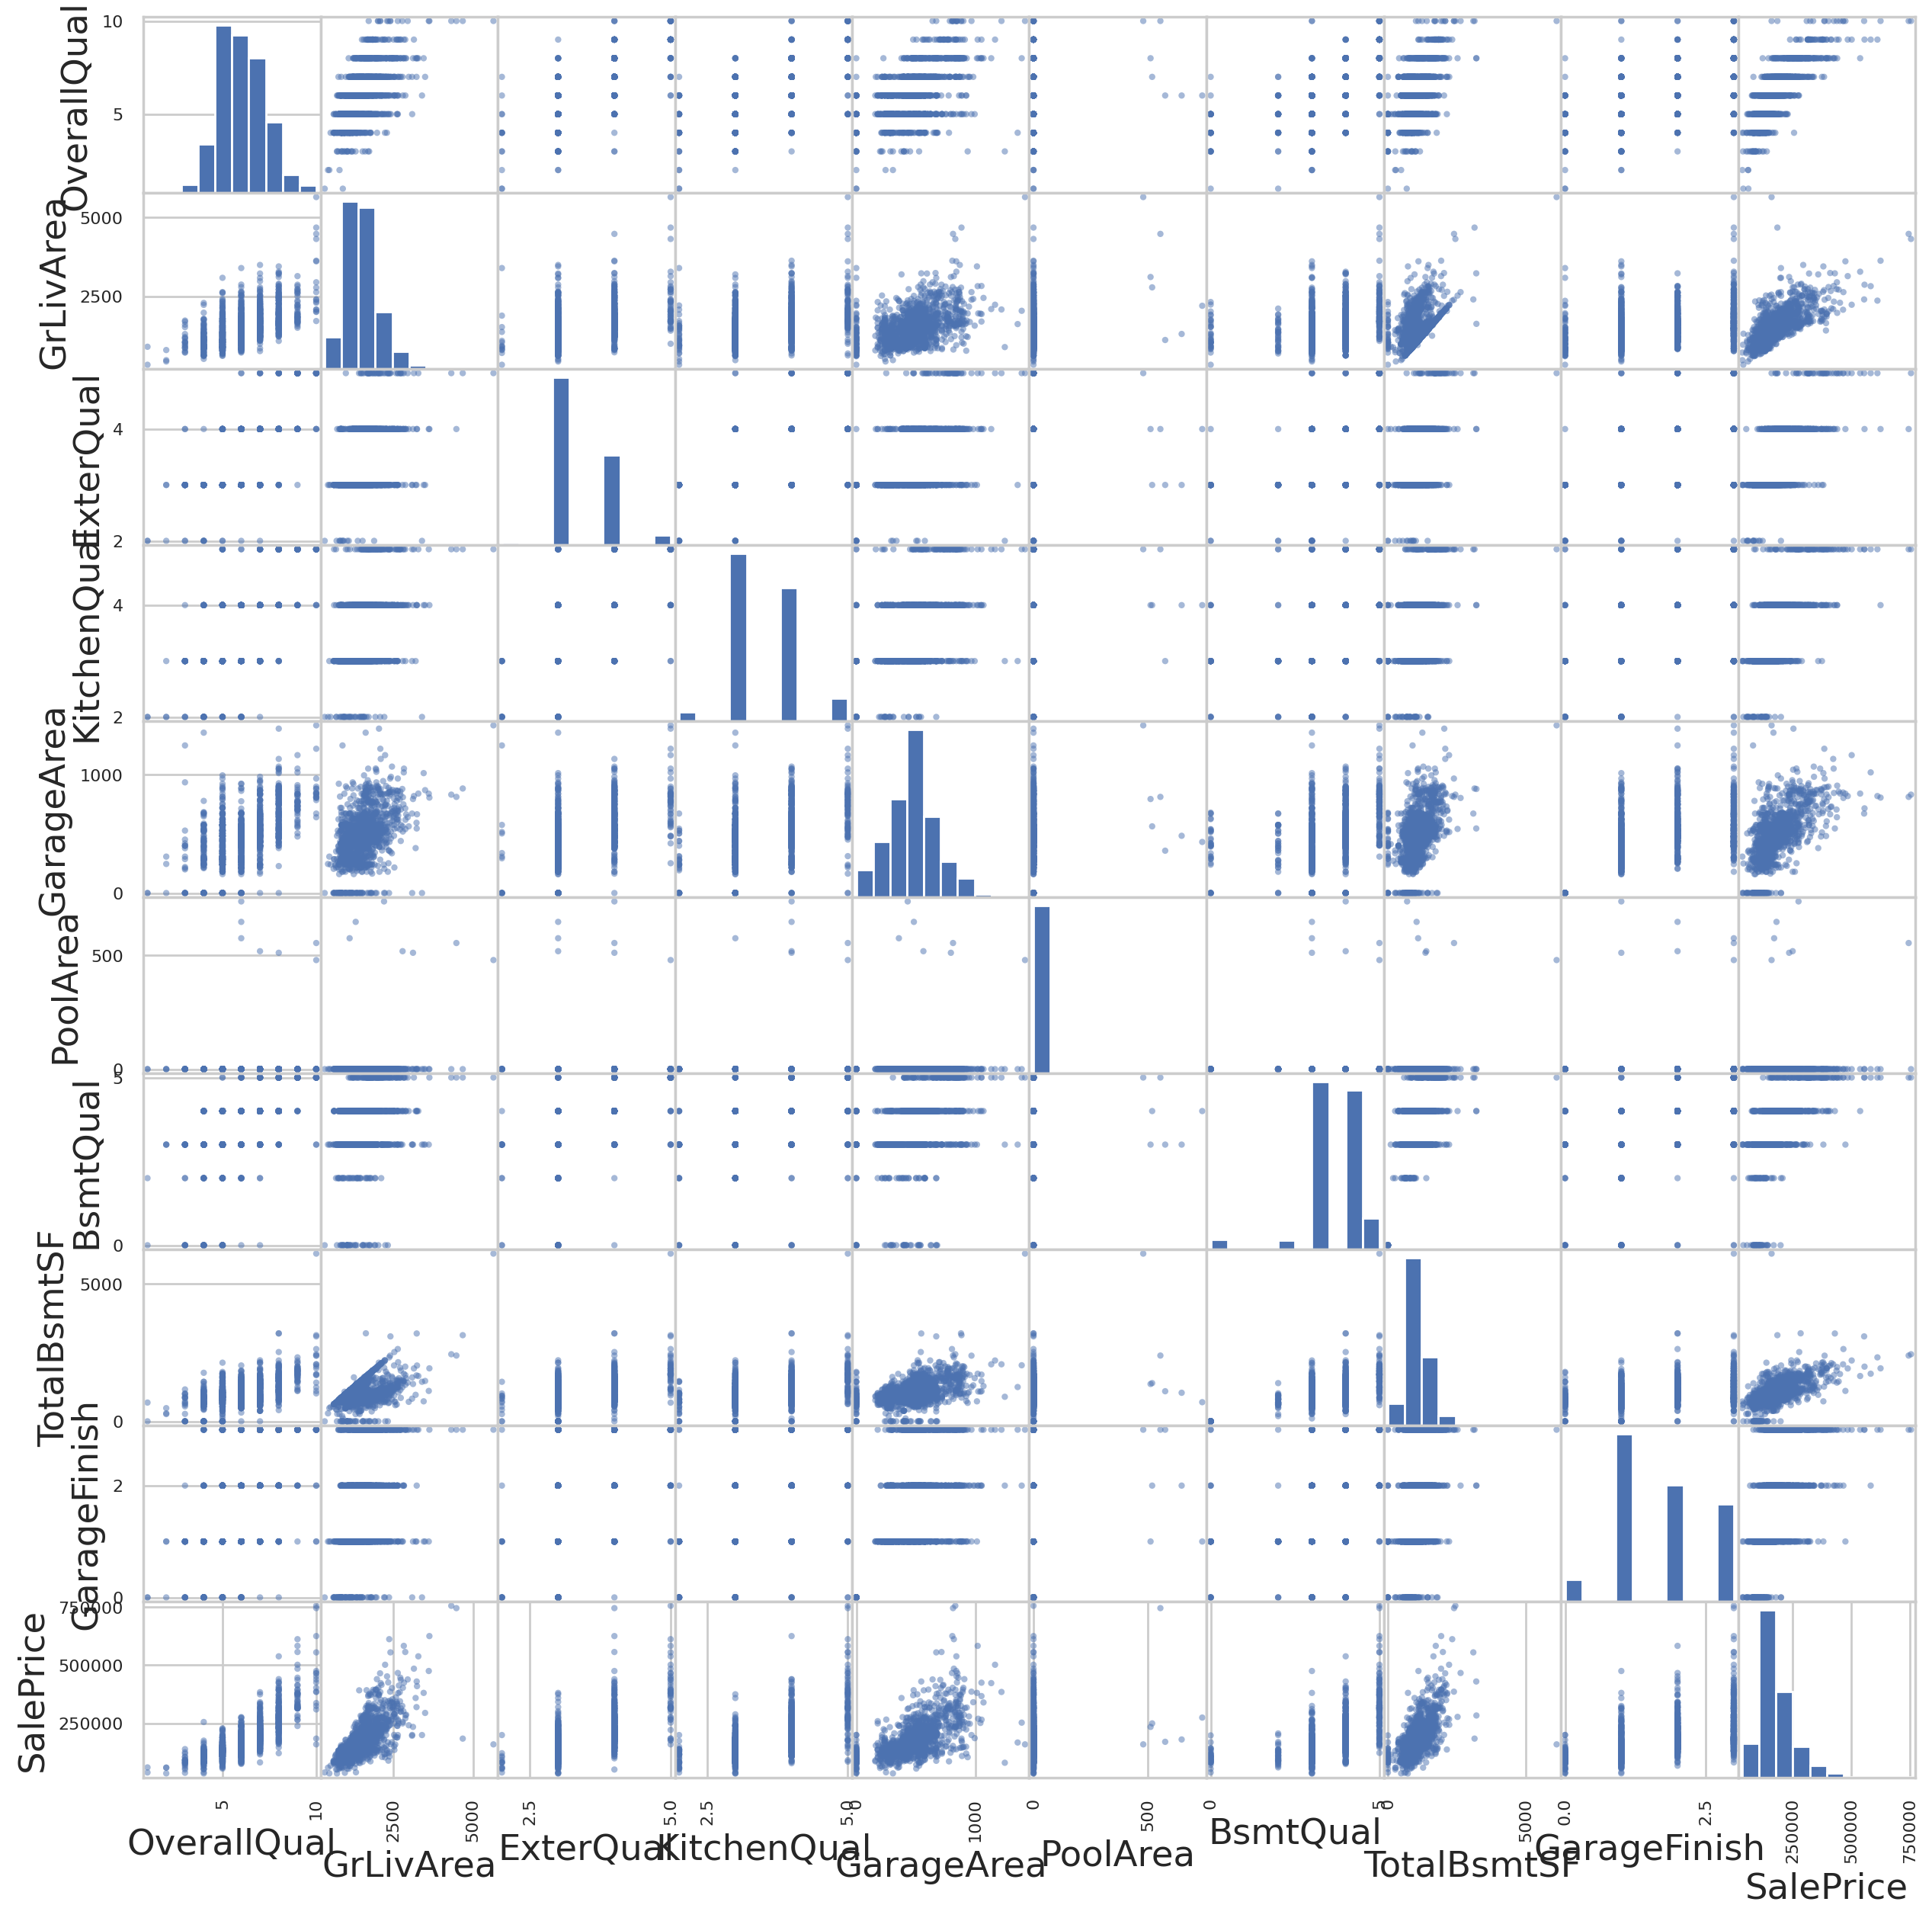

In [ ]:
pd.plotting.scatter_matrix(data, figsize=(15, 15))
print()

Сделайте вывод о данных. Опишите, нужна ли регуляризация и почему?

### Как пользоваться линейными моделями

Как можно догадаться, на практике никто не пишет заново свои линейные модели. Для машинного обучения часто используют библиотеку scikit learn, для аналитики statsmodels. С первой вы познакомитесь (или уже познакомились) на курсе по ML, мы же сконцентрируемся на второй.

Итак, библиотека statsmodels состоит из множества реализованных критериев и, как ни странно, статистических моделей. Основным плюсом является то, что нам не нужно реализовывать критериии вручную, все сделано за нас (это не значит что думать не надо!).

Начнем с линейной модели: для того, чтобы ее создать понадобится лишь одна строка.  Как видно в ячейке ниже мы задаем формулу того, какую модель мы хотим получить. В данном случае мы хотим предсказать ``SalePrice`` по взвешенной сумме из остальных признаков.

In [ ]:
formula = "SalePrice ~ " + " + ".join(useful_columns[:-1])

print(formula)

SalePrice ~ OverallQual + GrLivArea + ExterQual + KitchenQual + GarageArea + PoolArea + BsmtQual + TotalBsmtSF + GarageFinish


Теперь эту формулу мы просто передаем в модель, а так же подаем ей данные. В формуле написаны имена колонок из ``filtered_df``.

In [ ]:
simple_model = smf.ols(formula, data=data)

fitted_simple_model = simple_model.fit()

print(fitted_simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     581.5
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:55:38   Log-Likelihood:                -17429.
No. Observations:                1460   AIC:                         3.488e+04
Df Residuals:                    1450   BIC:                         3.493e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.483e+05   6394.344    -23.185   

После работы кода должна, выше должна получится примерно такая картинка:

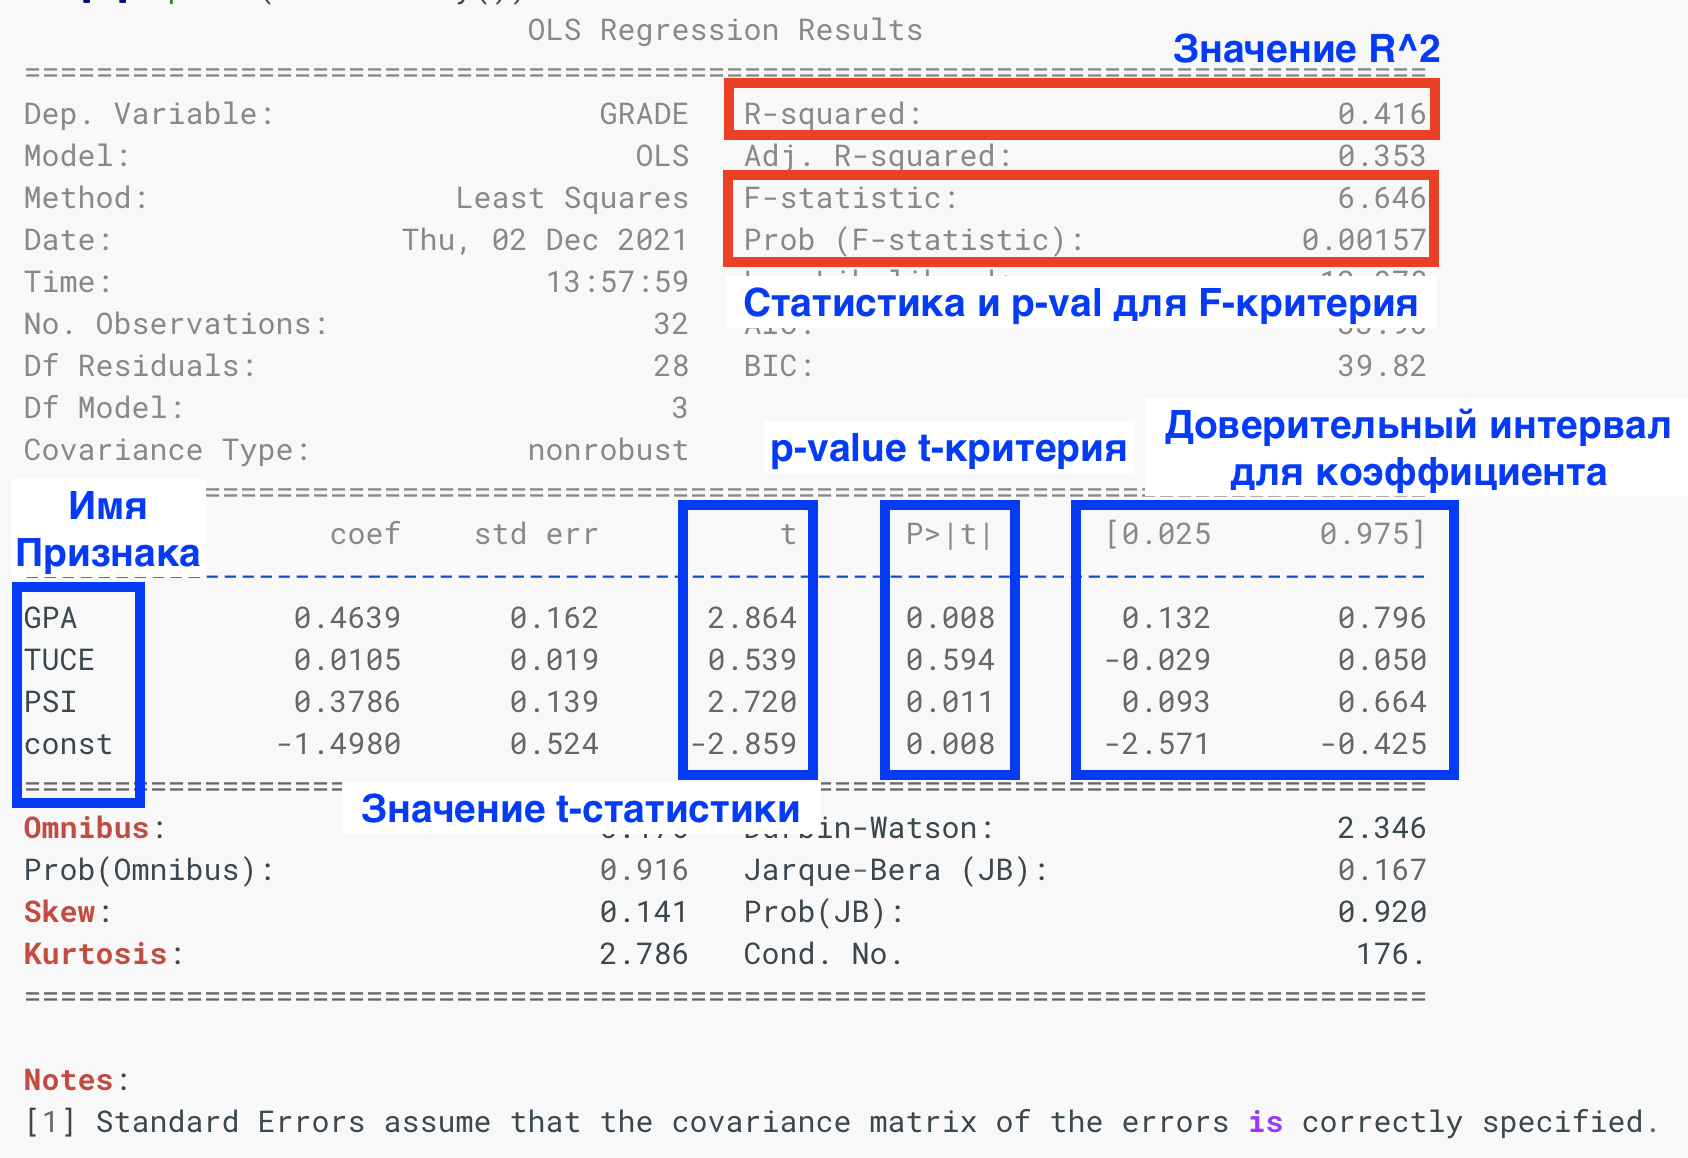


В примере название фичей намеренно изменены.

Можно заметить, что сверху располагается уже известный вам $R^2$. Далее чуть ниже располагются статистика и p-value (уровень достигаемой значимости) для F-критерия. Проверяется гипотеза о том, что наша модель работает лучше константы.

В мини-таблице есть проверка каждого признака на его значимость в модели с помощью t-критерия. Проверяется гипотеза о том, что модель без этого признака описывает не хуже, чем модель с этим признаком. Если значение p-value низкое, то, вероятно, признак статистически важен для модели. Таким образом можно осуществлять отбор признаков.




Сделайте выводы о том, согласуется ли отбор признаков при помощи p-value с естественной логикой самого признака.

Как мы видим из таблички, значение p-value равно 0 почти на всех фичах, кроме PoolArea. Как уже проверялось ранее, PoolArea почти не коррелирует со всеми остальными признаками. Возможно модель хочет лучше различать сильно линейно зависимые признаки (таких, как мы уже видели немало) и поэтому p-value для них сильно меньше, чем для признака, который почти не коррелирует с остальными, так как его очень легко различать.

### Гетероскедастичность ошибки

Оценка, полученная с помощью гауссовской линейной модели будет справдлива лишь при выполнении условия гомоскедастичности остатков. Для проверки на гомоскедастичность часто используют критерий Бройша — Пагана. Мы не будем вдаваться в детали и доказательство того, что критерий валидный и работает правильно. Итак, критерий Бройша — Пагана проверяет нулевую гипотезу о гомоскедастичности распределения данных против альтернативы, то есть гетероскедастичности. Если нулевая гипотеза отвергается то можно сказать, что данные распределены ГЕТЕРОскедастично. Мы этого не хотим.

Критерий реализован с помощью функции ``sms.diagnostic.het_breuschpagan``. Документацию можно найти [здесь](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_breuschpagan.html).

Остатки модели можно из поля ``fitted_model.resid``, а параметры из ``fitted_model.model.exog``.

Нас интересует p-value для множителя Лагранжа.

В ячейке ниже получите уровень достигаемой значимости для критерия Бройша — Пагана.

In [ ]:
p_val_het = sms.diagnostic.het_breuschpagan(resid=fitted_simple_model.resid,
                                            exog_het=fitted_simple_model.model.exog)[1]

print(f"p-value simple: {p_val_het}")

p-value simple: 5.4313611309869575e-95


Отвергается ли гипотеза о гомоскедастичности остатков (определение из будущего: гипотеза отвергается, если pvalue < 0.05 и это значит, что её утверждение полагается неверным)? Что это означает?

**Ответ:** p-value слишком мало, чтобы мы могли не отвергнуть эту теорию, придется ее отвергнуть. Это, к сожалению, означает, что данные распределены гетероскедастично.

В случаях, когда распределения остатков не является гомоскедастичном оценка по-прежнему остается несмещенной, однако стоит сделать некоторую поправку, на более высокую дисперсию. Поэтому значения F-критериев и t-критериев для коэффициентов стоит пересмотреть. Для таких случаев существует достаточно много различных поправок, одно из семейств таких поправок называется поправки Уайта на гетероскедастичность. Ниже мы попробуем использовать одну из поправок.

Для этого, в ячейке ниже, обучите линейную модель, но на этот раз передайте в метод ``.fit`` аргумент ``cov_type="HC1"``.

Получите summary для такой модели.

In [ ]:
filter_model = smf.ols(formula, data=data)
fitt_filter_model = filter_model.fit(cov_type='HC1')
print(fitt_filter_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     266.7
Date:                Mon, 04 Dec 2023   Prob (F-statistic):          5.44e-300
Time:                        20:02:19   Log-Likelihood:                -17429.
No. Observations:                1460   AIC:                         3.488e+04
Df Residuals:                    1450   BIC:                         3.493e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.483e+05   9507.281    -15.594   

Проанализируйте результаты. Как изменились p-value для t-критериев? Как изменился коэффициент $R^2$?

**Ответ:** Как мы видим $R^2$ совсем не изменился, а вот p-value в среднем увеличились (сильно у PoolArea, а также у TotalBsmtSF).

Теперь мы действительно можем оценивать то, насколько важен тот или иной признак. Давайте отфильтруем наш датасет и оставим в нем только значимые признаки на уровне значимости $\alpha = 0.05$. (используйте t-критерий).



Удалим фичи PoolArea.

In [ ]:
id = useful_columns.index('PoolArea')
filt_columns = useful_columns
filt_columns.pop(id)
filt_columns

['OverallQual',
 'GrLivArea',
 'ExterQual',
 'KitchenQual',
 'GarageArea',
 'BsmtQual',
 'TotalBsmtSF',
 'GarageFinish',
 'SalePrice']

Какие признаки оказались не значимы и почему?

**Ответ:** Для всех признаков, кроме PoolArea мы отвергаем гипотезу, что от них не зависит результат.

Теперь снова обучим новую модель только на значимых признаках и получим summary. Не забудьте про поправку Уайта!

In [ ]:
filtered_formula = "SalePrice ~ " + " + ".join(filt_columns[:-1])
filt_model = smf.ols(filtered_formula, data=data)
fit_model = filt_model.fit()
print(fit_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     653.7
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        20:07:47   Log-Likelihood:                -17429.
No. Observations:                1460   AIC:                         3.488e+04
Df Residuals:                    1451   BIC:                         3.492e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -1.48e+05   6392.591    -23.154   

Как изменился коэффициент $R^2$? Всегда ли бОльший $R^2$ говорит о правильной модели? Расскажите о своих рассуждениях!

**Ответ:** Как мы видим $R^2$ никак не изменился. Обычно, можно предполагать, что чем больше $R^2$, тем правильнее модель. Но при этом стоит не забывать про такие вещи, как линейность от регрессеров, некоррелируемость, нормальность ошибок и т.д. По факту $R^2$ показывает, как линейная модель объясняет дисперсию в переменнной.<br>

В википедии на этот счет есть очень интересная картинка: https://en.wikipedia.org/wiki/Anscombe%27s_quartet. Как мы видим, на ней 4 графика и для каждого $R^2 = 0.67$. Но при этом некорректно использовать гауссовскую линейную модель для всех случаев, кроме левого верхнего. Поэтому не всегда корректно судить о правильности модели только по $R^2$, хотя этот критерий и является действительно показательным в большинстве случаев.

### Преобразование целевого признака

Обратим свое внимание на целевую переменную. Ниже постройте гистограммы для признака ``SalePrice``. А так же для логарифма от ``SalePrice``. Сделайте это на разных картинках. Можно использовать subplot.

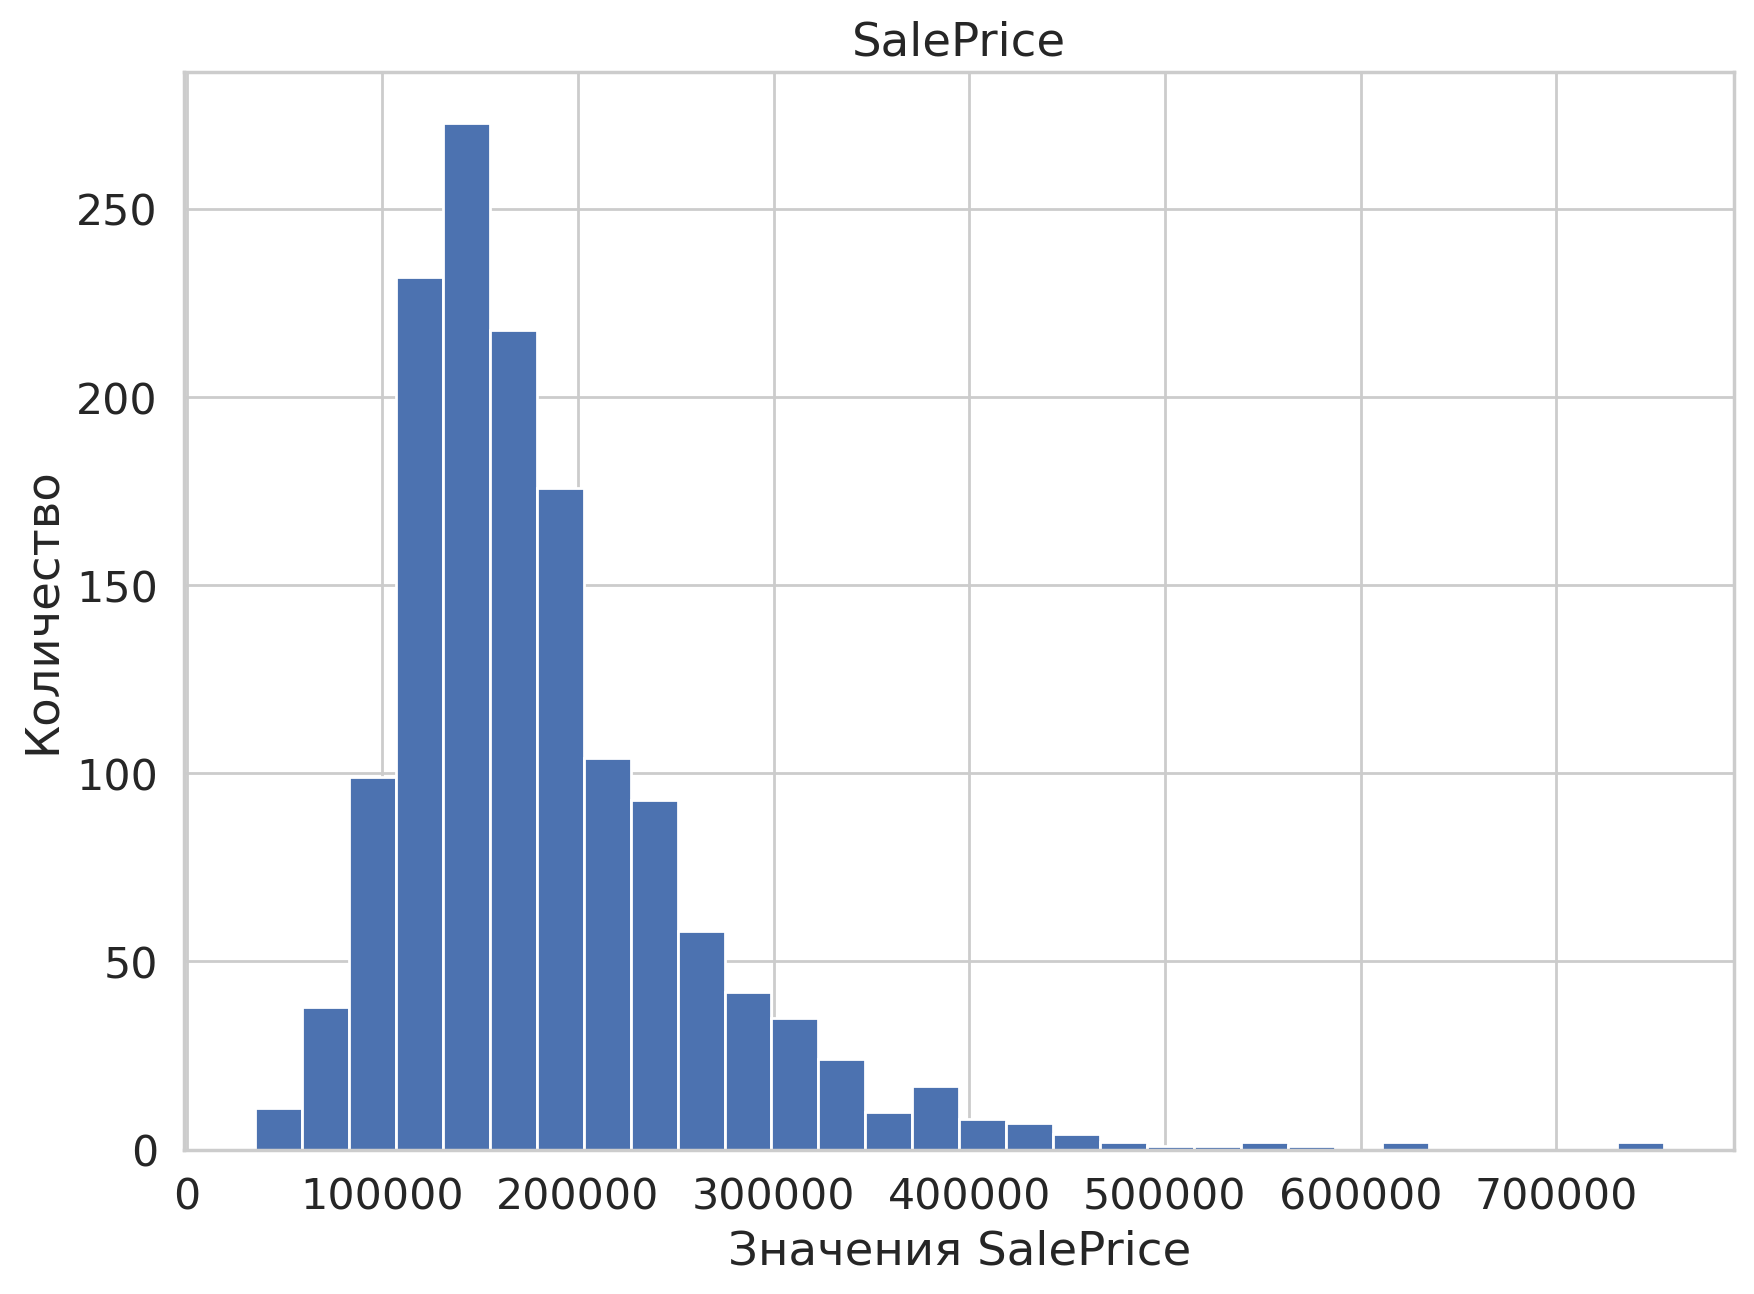

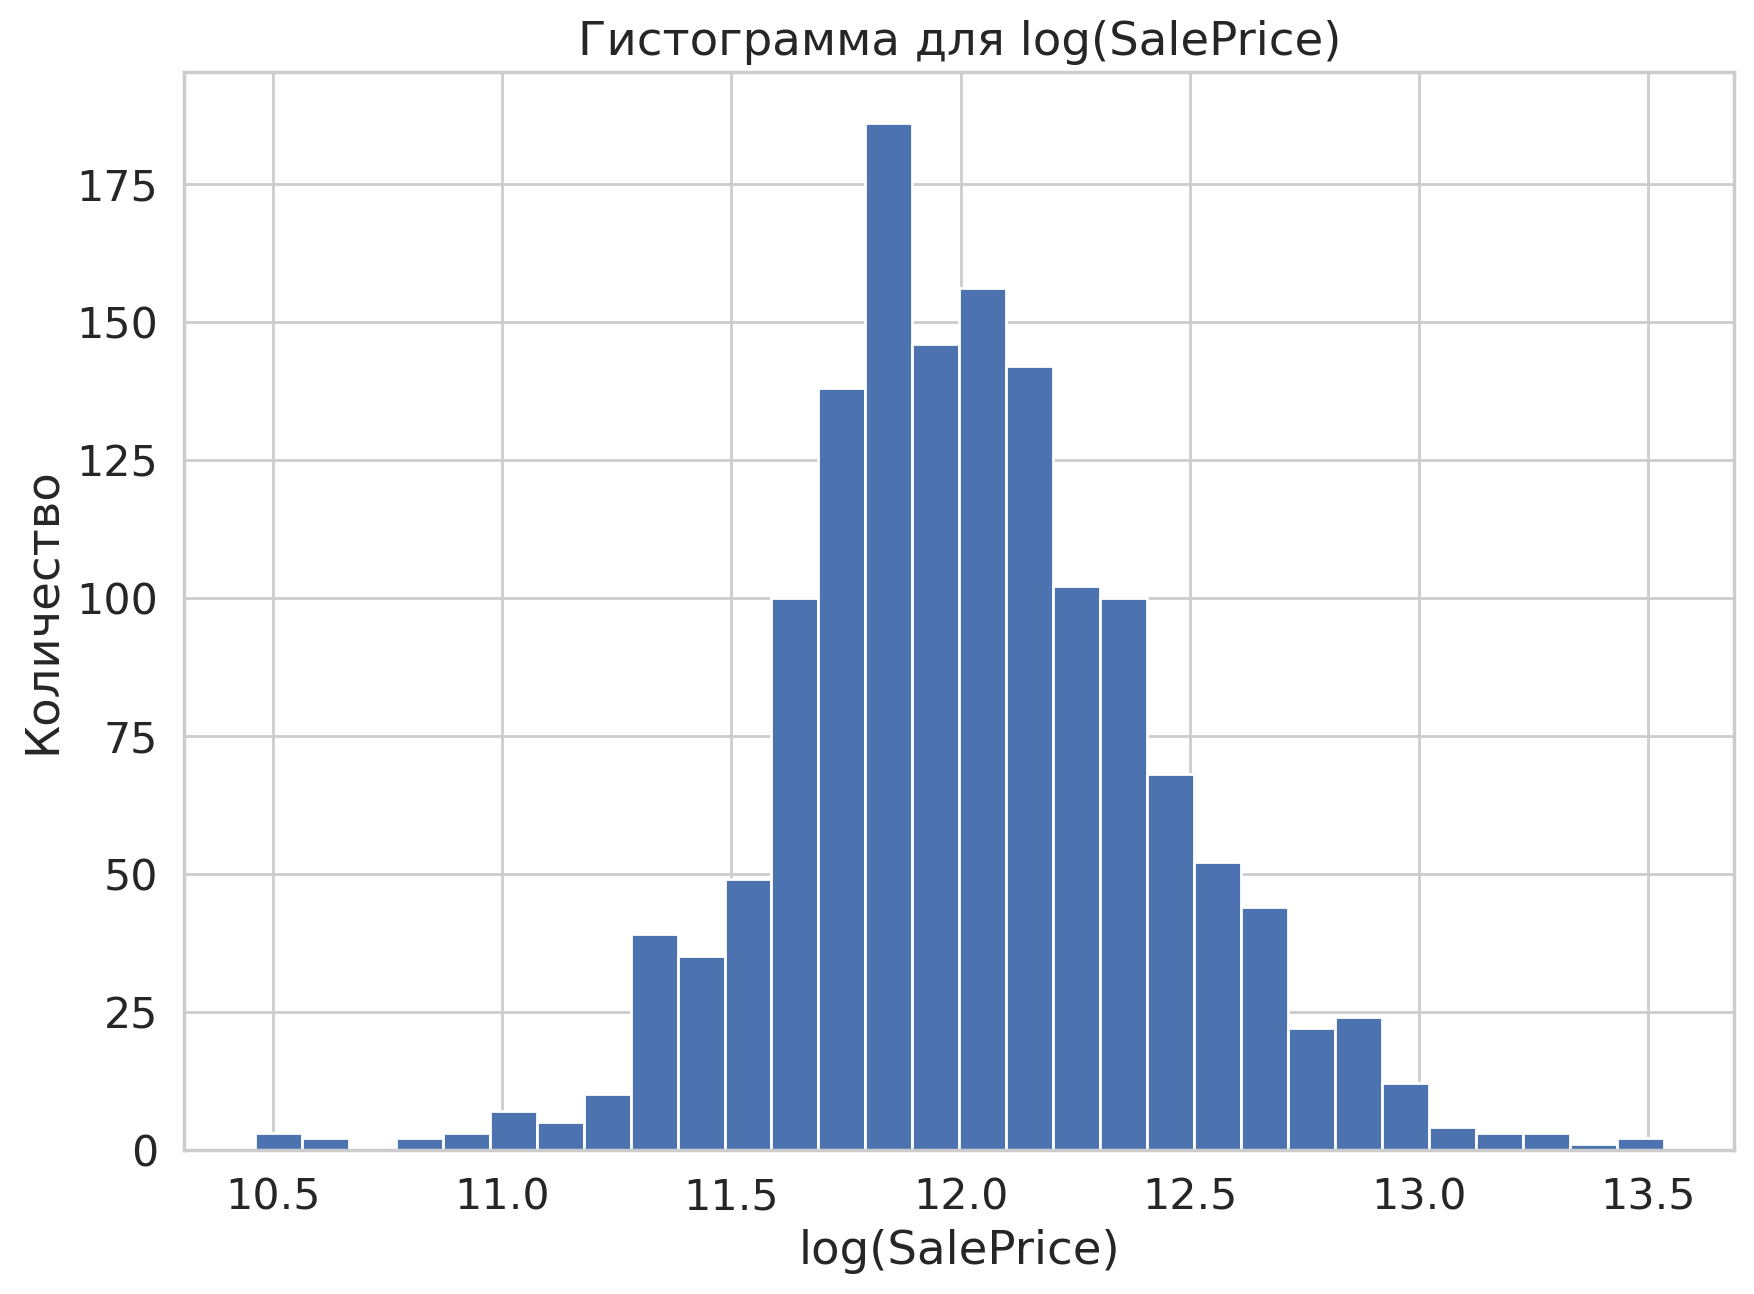

In [ ]:
plt.figure(figsize=(10, 7))
plt.hist(data['SalePrice'], bins = 30)
plt.title('SalePrice')
plt.xlabel('Значения SalePrice')
plt.ylabel('Количество')
plt.show()
plt.figure(figsize = (10, 7))
plt.hist(np.log(data["SalePrice"]), bins = 30)
plt.xlabel("log(SalePrice)")
plt.title("Гистограмма для log(SalePrice)")
plt.ylabel('Количество')
plt.show()

Какой из графиков выглядит более "Гауссовским"?

**Ответ:** Понятно, что график в логарифма выглядит более "Гауссовским", потому что данные имеют распределение очень похожее на нормальное, что важно в такого рода линейной модели.

Теперь давайте снова посмотрим на распределение остатков от линейной модели. Начертим qqplot для нормального распределения и гистограмму остатков.

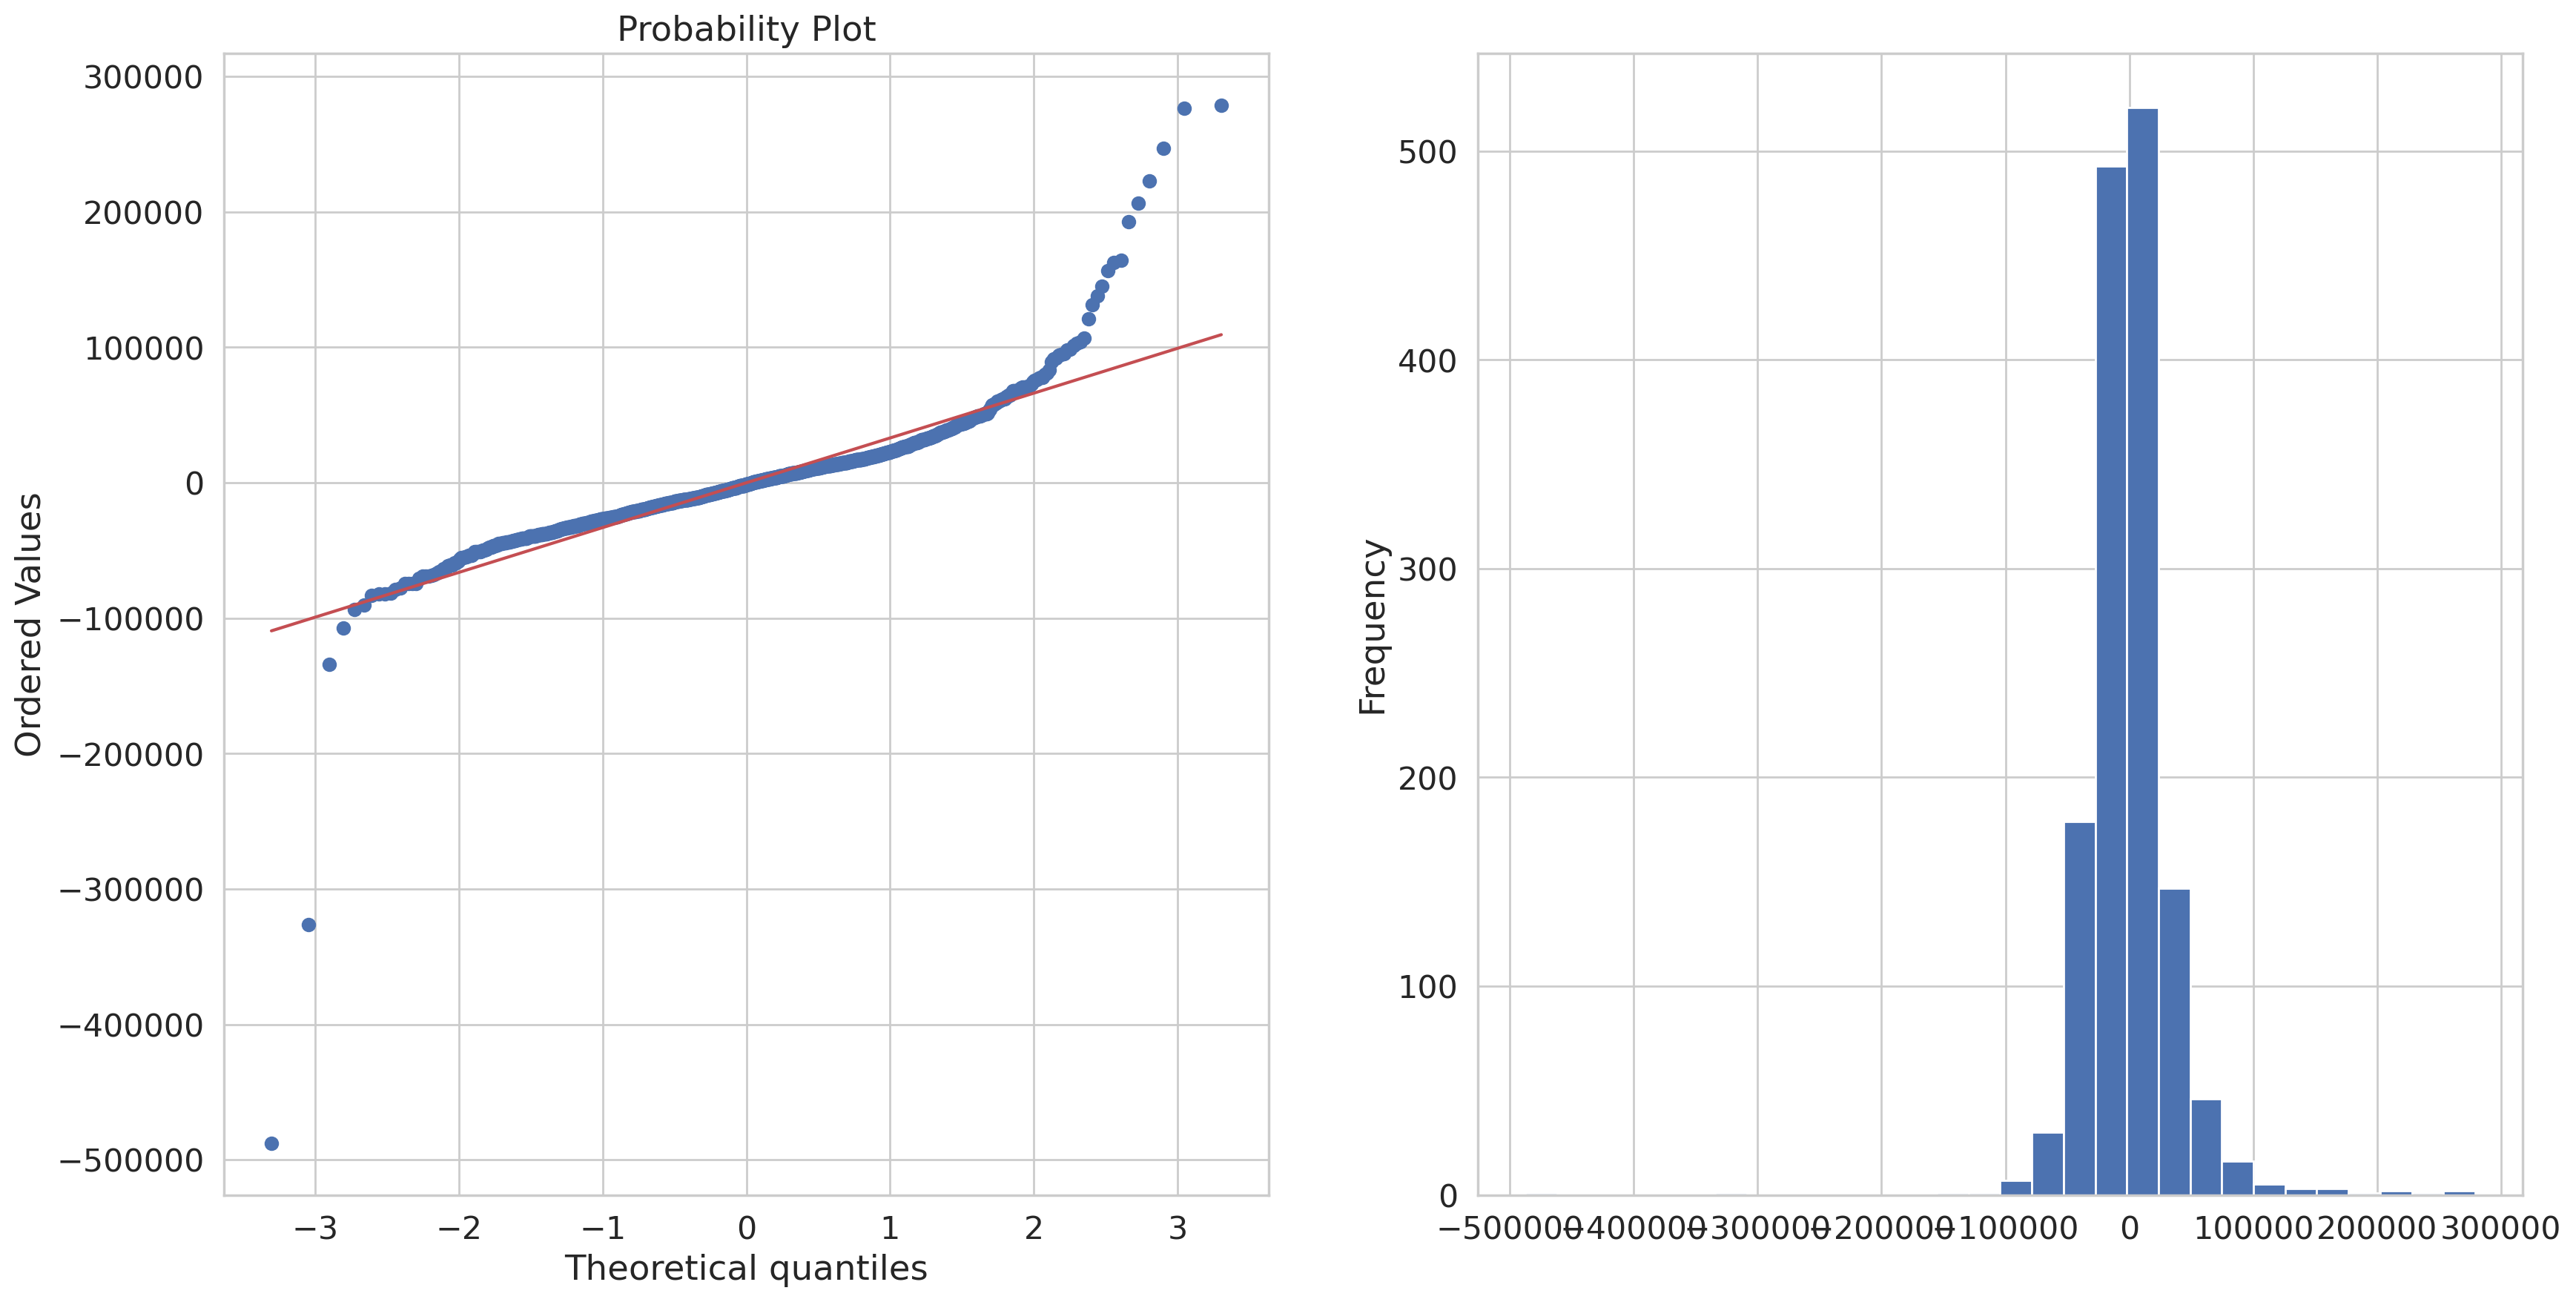

In [ ]:
import scipy

plt.figure(figsize=(20,10))
plt.subplot(121)
scipy.stats.probplot(fit_model.resid, dist="norm", plot=plt)
plt.subplot(122)
fit_model.resid.plot.hist(bins=30)
print()

Как вы считаете, можно ли сказать, что распределение остатков это нормальное распределение?

**Ответ:** В данной ситуации сложно сказать однозначно, но видно, что начальные и средние значения хорошо ложаться на прямую, а вот крайние не очень. Но в основном можно сказать, что да, это что-то очень похожее на нормальное распределение.

Давайте обучим модель предсказывать не SalePrice, а ее логарифм. Для этого снова обновим формулу для модели. Прелесть формул в том, что в них можно использовать операции из numpy. Например можно искать зависимость не от ``PoolArea``, а от ее квадрата, то есть ``np.power(PoolArea, 2)``. Достаточно просто добавить в формулу ..." + np.power(PoolArea, 2)" и все заработает!

В ячейке ниже обучите модель предсказывать логарифм SalePrice. Получите summary этой модели.

In [ ]:
log_formula =  "np.log(SalePrice) ~ " + " + ".join(filt_columns[:-1])
log_model = smf.ols(log_formula, data=data)
fit_log_model = log_model.fit(cov_type='HC1')
print(fit_log_model.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     599.1
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        20:32:25   Log-Likelihood:                 499.69
No. Observations:                1460   AIC:                            -981.4
Df Residuals:                    1451   BIC:                            -933.8
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.4070      0.035    298.718   

Как изменился коэффициент R^2? Модель лучше стала понимать данные?

**Ответ:** $R^2$ немного увеличился, а значит модель понимает данные теперь лучше.

Постройте графики, аналогичные тем, что встретились нам на две ячейки выше (qqplot и гистограмму остатков). Но на этот раз для модели, предсказывающией логарифм.

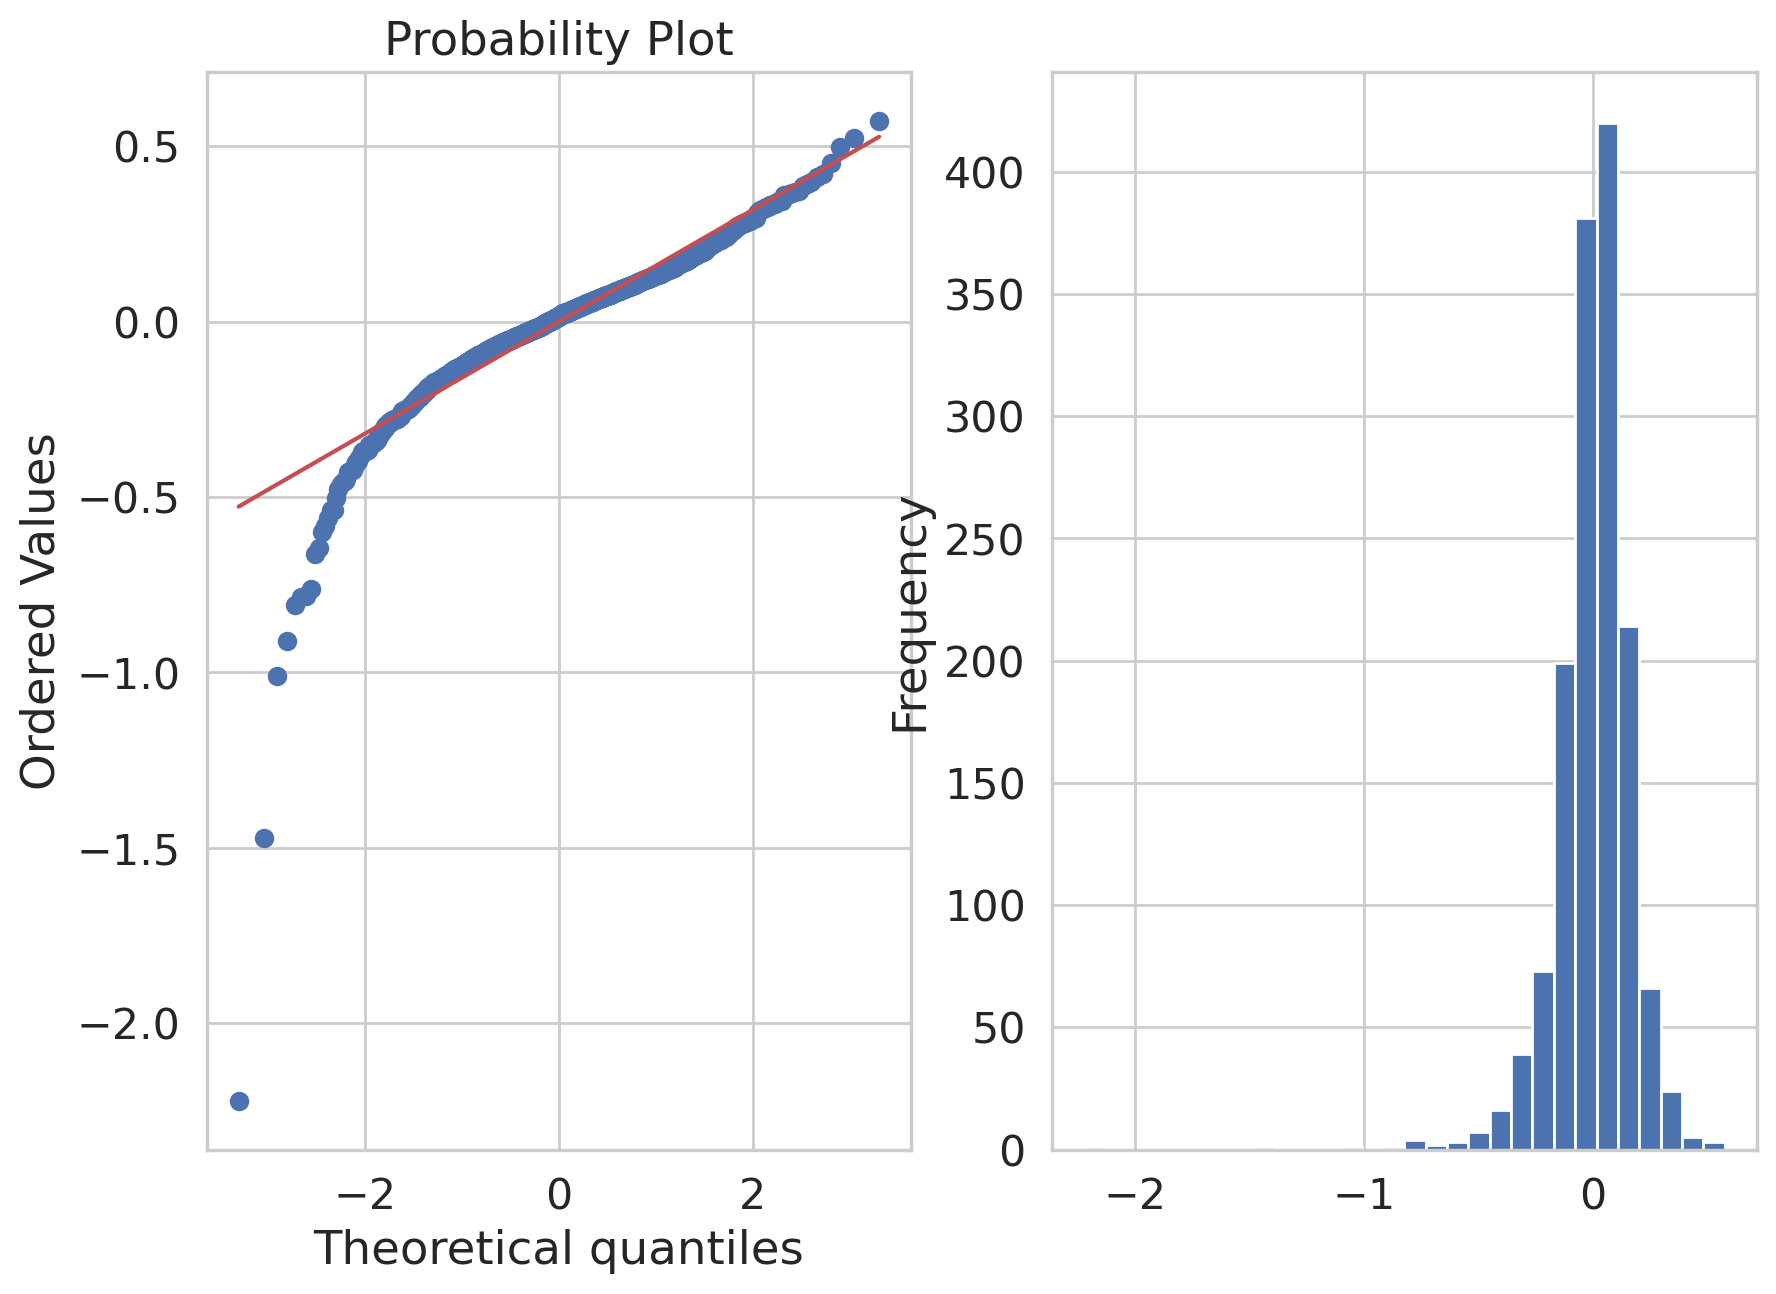

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(121)
scipy.stats.probplot(fit_log_model.resid, dist="norm", plot=plt)
plt.subplot(122)
fit_log_model.resid.plot.hist(bins = 30)
plt.show()

Как вы считаете, стоит ли предсказывать логарифм от цены? В каких случаях это полезно?

**Ответ:** Как мы видим, логарифмы лучше ложаться на прямую, а значит действительно лучше соответствуют нормальному распределению, что достаточно важно для гауссовской линейной модели. Также можно обосновать это тем, что логарифм понижает нам ошибку, так как сильно уменьшает значения, например, превращает экспоненты в полином. Значит используя линейную модель с логарифмами можно в некоторых случаях получить лучшие результаты! Возможно, логарифм может даже делать данные более гомоскедастичными, так как опять же уменьшает их значения и разброс.

## Бонусная часть (10 баллов)

Подойдём к задаче регрессии с байесовской точки зрения. Полезно изучить разделы 8.1, 8.2 конспекта Д.П.Вектрова (https://vk.com/doc126754362_500465695?hash=uU7RYUtCmrntB7ynduiZlYgZuR5C4oSnXqB5nXW0DEk&dl=votNcsozZKYk4ZLO546dYTZd17B3eHok2xSVQP6F6ic)

Только в начале дочитайте задание, а потом лезьте в конспект.

Мы Вам предлагаем увидеть, как при помощи байесовского подхода выбрать важные признаки регрессионной модели. Рекомендуем проделать выкладки без "подглядывания" в конспект.

1) Запишите байесовскую постановку задачи регрессии. Не забудьте про априорное распределение -- регуляризацию (пусть она для всех компонент одинаковая). Регуляризовать будем нормальным распределением, более того считать его компоненты независимыми (матрица ковариаций будет диагональна)

2) Каким будет аналитическое решение, если бы мы реализовывали "байес для бедных"? Какую роль играет регуляризация?

3) Теперь, когда Вы выяснили роль регуляризации давайте вместо диагональной матрицы с одинаковыми значениями на диагонали в качестве априорного распределения возьмём разные значения. Как изменится решение? Что произойдёт с теми признаками, у которых априорная дисперсия высокая? А низкая?

4) В вариационном байесовском выводе у Вас появился интересный объект в знаменателе -- интеграл по всему пространству параметров от регуляризированного правдоподобия. Это называется *обоснованностью* параметрической модели. Чем она выше -- тем лучше заданное семейство распределений описывает Ваши данные.

Прочитайте статью на википедии о бритве Оккама и критерии фальсифицируемости Поппера и ещё раз посмотрите на знаменатель. Порассуждайте о том, почему более обоснованные модели выше.

**Ваш философский ответ:**

А теперь откройте главу 8 конспекта Ветрова и изучите алгоритм максимизации обоснованности.

Напишите его.

Изучите дисперсии, которые получатся после 30 итераций (или сколько Вам понадобится для сходимости). Подумайте, почему алгоритм счёл одни признаки полезнее других. Визуализируйте распределение признака и его дисперсию. Сделайте выводы.

**Вывод:**